# Executive Summary

## Context

In Burma, coach buses are still the main medium for inter-city travel for affordability as well as reliability (planes are more susceptible to delays). 

MM Bus Ticket (MBT) has emerged as the market leader for bus operators that want to manage and sell their seat inventory on a digital platform. MBT is the market leader by sales volume as well as by transaction value. 

MBT is primarily a B2B platform. According to the owners, approximately 80% of the transactions were updated by the bus operators and travel agents  (B2B partners) - i.e. most travellers place their bookings via phone or in person with either a bus operator or travel agent, and those transactions are then updated by the B2B partners. 

The other tickets trickle in from the website (popular with foreign visitors) and from mobile wallets (similar to purchasing movie tickets from DBS Paylah). 

However, since MBT was started a few years ago, the company has primarily focused on its B2B operations. The business owners are the main people driving the business decisions, and that again is founded on experience and gut feel. The owners have decided that it's timely to start embracing data-based decision-making whenever possible. 

In addition, MBT is also considering expanding its portfolio to go into bus operations, so the owners want to know which are the best routes they should consider.

## Problem Statement

Using the dataset provided:

* find out the top 10 routes by ticket sales volume
* find out the top 10 routes by ticket sales value
* predict the number of tickets expected to be sold for the top 10 routes (by ticket sales volume)

As mentioned, knowing the top 10 routes will help MBT to be more targeted in undertaking market research on the most profitable routes to operate.

The prediction model will also be useful in understanding which are the key features (factors) that impact ticket sales e.g. trip departure timing (is it evening? morning?), trip duration (long-haul vs short-haul), seat category.


## How the notebooks are organized

**1_EDA**

This notebook is where I made data retrieval from the 7GB postgres database, and also contains the various attempts made at understanding my dataset - including the many profile_report() and preliminary visualisations.

Analysis on the top 10 subroutes is also in this notebook. 

**2_modeling**

This notebook contains the various trial-and-error attempts at modeling which includes
* trying different groupby conditions
* trying different regression models (linear, lasso, decision tree regressor, random forest regressor) + gridsearching hyperparameters
* trying Polynomial Features to see if there are note-worthy interaction between features

Results of the numerous modeling attemps have also been captured.

**3_final_modeling**

Having concluded that Random Forest Regressor was best at predicting (bsaed on R2 score) number of bus tickets, in this notebook I focused on tuning the hyperparameters by gridsearching various permutations.

I also tried to run gridsearch on Decision Tree Regressor to arrive at a model that performs reasonably okay - the objective is to use that model to find out which are the top 3 predictors of bus ticket sales. 

# real-world information
    
Notes from interviews with the business owners

**Purchase channels**
* direct from mmbusticket.com
* via mobile wallets (e.g. MPU, KBZ, CB, wave money)
* from travel agents
* from bus operators directly at terminals

Generally, we would consider ticket purchases made from the website and via mobile wallets to be direct purchases for two reasons
* the mobile interface is directly powered by MM Bus Ticket rather than an external party
* passenger details are entered by the purchaser himself/herself rather than by a counter staff at a travel agency/bus terminal


**Bus routes**
* Most cities only have one bus terminal. Only a handful of bigger cities (e.g. Yangon, Mandalay) have more than one bus terminal. 
* However, for a given route (e.g. Yangon-Mandalay), all buses depart from and arrive at the same bus terminals.
    * Hence, exact bus terminal information is not captured in the database.
    * This means we will not need to investigate if customers have preferred bus terminals because there isn't even a choice of bus terminals to begin with.
    
**Bus and seat types**
* Unlike in the case of airlines, bus operators in Burma don't have the practice of offering different seat categories within the same trip.
    * Therefore, all seats within a given trip (assuming the same sub-route) have the same price formula. 
* Instead, price differentiation happens at the bus type level (e.g. 'VIP', 'First Class'). So an operator for the Yangon-Mandalay route might offer several concurrent trips using different types of buses. A 'First Class' bus is typically more expensive than a 'Standard' bus.
    * However, from a technical viewpoint, it should be noted that these bus types are not normalized. For instance, `tk_bus_type` has multiple rows that have `description` = 'VIP' all with different bus. There is also no consistent format to the `description` field - e.g. there is 'Standard', ' Standard - Scania', 'Standard 44', 'Standard 49' etc. 
    * While we might be able to safely assume that 'First Class' is superior t 'Standard', it's harder to tell if 'Premier Class' is equivalent/higher/lower than 'First Class'. At best, these can be considered nominal categories rather than ordinal. 
* Neither the website nor the mobile interface (i.e. for mobile wallets) provide information on the amenities (e.g. whether seats can be reclined, if charging points are available at each seat) offered by each bus type. 
    * This means that if a foreign tourist is looking to make a direct purchase, he/she can only assume that a pricier ticket would offer more comfort than a cheaper ticket. 
    * Some locals might have a better idea of the differences among bus types/companies based on experience or here-say.
    * customers making purchases made via agents/bus operators may also be better informed because they have the opportunity to ask counter staff for clarifications.

# setting up
## imports and settings

In [1]:
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import capstone_connect as creds
import pandas.io.sql as psql
import pandas_profiling

# for datetime manipulation
import datetime as dt

In [7]:
## optional pip installs

# !pip install pandas_profiling


In [2]:
# plotting related imports and settings

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


In [3]:
# changing our pandas settings so that we can view all columns 
pd.set_option('max_columns', 999)

## postgres database functions

In [4]:
# ## ****** LOAD PSQL DATABASE ***** ##
# # Set up a connection to the postgres server.
# conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
# +" password="+ creds.PGPASSWORD

# print(conn_string)

# conn=psycopg2.connect(conn_string)


# print("Connected!")

# # Create a cursor object
# cursor = conn.cursor()


# def load_data(schema, table):

#     sql_command = "SELECT * FROM {}.{} LIMIT 100;".format(str(schema), str(table))
#     print (sql_command)

#     # Load the data
#     data = pd.read_sql(sql_command, conn)

#     print(data.shape)
#     return (data)

host=localhost port=5432 dbname=postgres user=postgres password=admin
Connected!


In [4]:
# this function will allow us to make any SQL calls on the database

def query_db(sql):
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
    +" password="+ creds.PGPASSWORD
    conn=psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
 
    print (sql)

    # Load the data
    data = pd.read_sql(sql, conn)

    print("Rows and columns returned:", data.shape)
    return (data)

# loading COLUMNS.csv for meta data info

**What we're doing**

* putting the meta data info here for ease of reference
* zooming into rows where table_name contains the substring 'tk_'

In [6]:
cols_df = pd.read_csv('COLUMNS.csv')
print(cols_df.shape)
cols_df.head()

(3436, 44)


,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,numeric_precision,numeric_precision_radix,numeric_scale,datetime_precision,interval_type,interval_precision,character_set_catalog,character_set_schema,character_set_name,collation_catalog,collation_schema,collation_name,domain_catalog,domain_schema,domain_name,udt_catalog,udt_schema,udt_name,scope_catalog,scope_schema,scope_name,maximum_cardinality,dtd_identifier,is_self_referencing,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,innoticket_restore4,pg_catalog,pg_proc,proname,1,NaN,NO,name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,name,NaN,NaN,NaN,NaN,1,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1,innoticket_restore4,pg_catalog,pg_proc,pronamespace,2,NaN,NO,oid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,oid,NaN,NaN,NaN,NaN,2,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
2,innoticket_restore4,pg_catalog,pg_proc,proowner,3,NaN,NO,oid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,oid,NaN,NaN,NaN,NaN,3,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3,innoticket_restore4,pg_catalog,pg_proc,prolang,4,NaN,NO,oid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,oid,NaN,NaN,NaN,NaN,4,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
4,innoticket_restore4,pg_catalog,pg_proc,procost,5,NaN,NO,real,NaN,NaN,24.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,float4,NaN,NaN,NaN,NaN,5,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES


In [7]:
# storing the list of unique tables that contain the substring 'tk_' in the table name
tk_table_names = [i for i in cols_df["table_name"].unique() if "tk_" in i]

In [8]:
tk_table_names

['tk_seat',
 'a_tk_seat',
 'tk_account_transaction',
 'tk_agent_commission',
 'tk_agent_commission_for_trip',
 'tk_agent_group',
 'tk_agent_reporting_group',
 'tk_agent_user_account',
 'tk_agent_user_profile',
 'tk_allotment_template',
 'tk_booking_detail',
 'tk_booking_detail_item',
 'tk_booking_log',
 'tk_booking_ref_number',
 'tk_bus',
 'tk_bus_creation_template',
 'tk_bus_operator',
 'tk_bus_operatorgate',
 'tk_bus_refill',
 'tk_bus_schedule_template',
 'tk_bus_type',
 'tk_car_main',
 'tk_car_main_template',
 'tk_cargo',
 'tk_cargo_item',
 'tk_cargo_template',
 'tk_cargo_template_item',
 'tk_city',
 'tk_contactdetail',
 'tk_daily_schedular_template',
 'tk_deposit_account',
 'tk_expense',
 'tk_expense_item',
 'tk_expense_template',
 'tk_expense_template_item',
 'tk_gate',
 'tk_gate_fee',
 'tk_gate_fee_template',
 'tk_general_case_service',
 'tk_general_case_service_template',
 'tk_general_case_service_template_item',
 'tk_invoice',
 'tk_invoice_item',
 'tk_location',
 'tk_operator_p

In [9]:
tk_df = cols_df[cols_df['table_name'].str.contains('tk_')]
print(tk_df.shape)
tk_df.head()

(1784, 44)


,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,numeric_precision,numeric_precision_radix,numeric_scale,datetime_precision,interval_type,interval_precision,character_set_catalog,character_set_schema,character_set_name,collation_catalog,collation_schema,collation_name,domain_catalog,domain_schema,domain_name,udt_catalog,udt_schema,udt_name,scope_catalog,scope_schema,scope_name,maximum_cardinality,dtd_identifier,is_self_referencing,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
1652,innoticket_restore4,public,tk_seat,bus_id,2,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,2,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1653,innoticket_restore4,public,tk_seat,bus_type_id,3,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,3,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1654,innoticket_restore4,public,tk_seat,seat_column,4,NaN,YES,integer,NaN,NaN,32.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int4,NaN,NaN,NaN,NaN,4,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1655,innoticket_restore4,public,tk_seat,confirmed_account_id,5,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,5,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1656,innoticket_restore4,public,tk_seat,created_by,6,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,6,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES


# tk_ticket

In [10]:
tk_ticket = load_data('public', 'tk_ticket')
tk_ticket.head()

SELECT * FROM public.tk_ticket LIMIT 100;
(100, 34)


,ticket_id,booking_detail_id,booking_detail_item_id,bus_no,created_by,creation_date,foreigner,gender,is_checkin,modified_by,modified_date,operator_id,sub_route_id,status,traveller_group_type,vendor_id,version,commission_amt,commission_amt_cur,discount_amt,discount_cur,original_amt,original_amt_cur,service_fee_amt,service_fee_cur,ticket_fee_amt,ticket_fee_cur,traveller_id,seat_id,trip_id,bus_id,bustypeid,seatno,seat_type
0,156,266,415,,41,2016-07-30 01:35:54.430,False,None,None,NaN,NaT,3,92.0,CANCEL,FEMALE_ONLY,None,2,1000.0,MMK,None,None,10700.0,MMK,200.0,MMK,9700.0,MMK,None,51555,1036,1036.0,10.0,26,0.0
1,157,267,416,,23,2016-07-30 08:56:23.550,False,None,None,NaN,NaT,2,48.0,CONFIRMED,FEMALE_ONLY,None,1,2000.0,MMK,None,None,18500.0,MMK,200.0,MMK,16500.0,MMK,None,21018,421,421.0,4.0,I3,1.0
2,158,268,417,,25,2016-07-30 10:43:40.610,False,None,None,NaN,NaT,2,67.0,CONFIRMED,MALE_ONLY,None,1,2000.0,MMK,None,None,18500.0,MMK,200.0,MMK,16500.0,MMK,None,28105,563,563.0,4.0,B2,0.0
3,159,268,418,,25,2016-07-30 10:43:40.622,False,None,None,NaN,NaT,2,67.0,CONFIRMED,MALE_ONLY,None,1,2000.0,MMK,None,None,18500.0,MMK,200.0,MMK,16500.0,MMK,None,28106,563,563.0,4.0,B1,1.0
4,18,56,62,,13,2016-07-07 23:10:09.883,False,None,None,NaN,NaT,2,NaN,CANCEL,MALE_ONLY,None,3,1000.0,MMK,None,None,9500.0,MMK,200.0,MMK,8500.0,MMK,None,1866,38,NaN,NaN,None,NaN


In [11]:
tk_df.head()

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,numeric_precision,numeric_precision_radix,numeric_scale,datetime_precision,interval_type,interval_precision,character_set_catalog,character_set_schema,character_set_name,collation_catalog,collation_schema,collation_name,domain_catalog,domain_schema,domain_name,udt_catalog,udt_schema,udt_name,scope_catalog,scope_schema,scope_name,maximum_cardinality,dtd_identifier,is_self_referencing,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
1652,innoticket_restore4,public,tk_seat,bus_id,2,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,2,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1653,innoticket_restore4,public,tk_seat,bus_type_id,3,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,3,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1654,innoticket_restore4,public,tk_seat,seat_column,4,NaN,YES,integer,NaN,NaN,32.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int4,NaN,NaN,NaN,NaN,4,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1655,innoticket_restore4,public,tk_seat,confirmed_account_id,5,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,5,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
1656,innoticket_restore4,public,tk_seat,created_by,6,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,6,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES


In [12]:
def display_meta(tbl_name):
    
    # print number of tables
    
    print(f"Number of attributes in {tbl_name}: {tk_df[tk_df['table_name'] == tbl_name].shape}")
    
    # extracting all rows where table_name match tbl_name
    # sorting by ordinal_position to make it easier to find the primary key
    df = tk_df[tk_df['table_name'] == tbl_name].sort_values(by='ordinal_position', ascending=True)
          
    # to display the number of not nullable columns (e.g. primary key, foreign key)
    print("Number of not nullable columns is: ",df[df['is_nullable'] == 'NO']['is_nullable'].count())
          
    display(df)
    
    return df

In [13]:
meta_ticket = display_meta('tk_ticket')

Number of attributes in tk_ticket: (34, 44)
Number of not nullable columns is:  1


,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,numeric_precision,numeric_precision_radix,numeric_scale,datetime_precision,interval_type,interval_precision,character_set_catalog,character_set_schema,character_set_name,collation_catalog,collation_schema,collation_name,domain_catalog,domain_schema,domain_name,udt_catalog,udt_schema,udt_name,scope_catalog,scope_schema,scope_name,maximum_cardinality,dtd_identifier,is_self_referencing,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
3424,innoticket_restore4,public,tk_ticket,ticket_id,1,nextval('tk_ticket_ticket_id_seq'::regclass),NO,integer,NaN,NaN,32.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int4,NaN,NaN,NaN,NaN,1,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3093,innoticket_restore4,public,tk_ticket,booking_detail_id,2,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,2,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3094,innoticket_restore4,public,tk_ticket,booking_detail_item_id,3,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,3,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3095,innoticket_restore4,public,tk_ticket,bus_no,4,NaN,YES,character varying,255.0,1020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,varchar,NaN,NaN,NaN,NaN,4,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3096,innoticket_restore4,public,tk_ticket,created_by,5,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,5,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3097,innoticket_restore4,public,tk_ticket,creation_date,6,NaN,YES,timestamp without time zone,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,timestamp,NaN,NaN,NaN,NaN,6,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3098,innoticket_restore4,public,tk_ticket,foreigner,7,NaN,YES,boolean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,bool,NaN,NaN,NaN,NaN,7,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3099,innoticket_restore4,public,tk_ticket,gender,8,NaN,YES,integer,NaN,NaN,32.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int4,NaN,NaN,NaN,NaN,8,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3100,innoticket_restore4,public,tk_ticket,is_checkin,9,NaN,YES,boolean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,bool,NaN,NaN,NaN,NaN,9,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES
3101,innoticket_restore4,public,tk_ticket,modified_by,10,NaN,YES,bigint,NaN,NaN,64.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,innoticket_restore4,pg_catalog,int8,NaN,NaN,NaN,NaN,10,NO,NO,NaN,NaN,NaN,NaN,NaN,NaN,NEVER,NaN,YES


In [14]:
meta_ticket[meta_ticket['is_nullable'] == 'NO']['is_nullable'].count()

1

## extracting only 2019 records from tk_ticket



In [15]:
sql_tk_ticket19 = ("SELECT * FROM public.tk_ticket \
                    WHERE date_part('year', creation_date) = '2019' \
                    ORDER BY creation_date DESC \
                ")

ticket_2019 = query_db(sql_tk_ticket19)


SELECT * FROM public.tk_ticket                     WHERE date_part('year', creation_date) = '2019'                     ORDER BY creation_date DESC                 
Rows and columns returned: (6909835, 34)


In [16]:
ticket_2019.head()

,ticket_id,booking_detail_id,booking_detail_item_id,bus_no,created_by,creation_date,foreigner,gender,is_checkin,modified_by,modified_date,operator_id,sub_route_id,status,traveller_group_type,vendor_id,version,commission_amt,commission_amt_cur,discount_amt,discount_cur,original_amt,original_amt_cur,service_fee_amt,service_fee_cur,ticket_fee_amt,ticket_fee_cur,traveller_id,seat_id,trip_id,bus_id,bustypeid,seatno,seat_type
0,19351894,11906166,19324284,2,19880,2019-10-22 02:56:58.864,False,None,None,19880,2019-10-22 02:56:58.864,89,3266,CONFIRMED,MALE_ONLY,None,1,0.0,MMK,NaN,None,4000.0,MMK,None,None,4000.0,MMK,None,42337193,790869,790906,390,12,1
1,19351893,11906165,19324282,6 Bus,21478,2019-10-22 02:38:39.933,False,None,None,21478,2019-10-22 02:38:39.933,21,672,CONFIRMED,FEMALE_ONLY,None,1,0.0,MMK,NaN,None,7500.0,MMK,None,None,7500.0,MMK,None,40914643,764564,764600,80,25,1
2,19351892,11906165,19324283,6 Bus,21478,2019-10-22 02:38:39.927,False,None,None,21478,2019-10-22 02:38:39.927,21,672,CONFIRMED,FEMALE_ONLY,None,1,0.0,MMK,NaN,None,7500.0,MMK,None,None,7500.0,MMK,None,40914653,764564,764600,80,26,0
3,19351891,11906164,19324281,1,19880,2019-10-22 02:25:07.563,False,None,None,19880,2019-10-22 02:25:07.563,89,3266,CONFIRMED,MALE_ONLY,None,1,0.0,MMK,NaN,None,4000.0,MMK,None,None,4000.0,MMK,None,42333898,790814,790851,390,12,1
4,19351890,11906163,19324280,1,19880,2019-10-22 02:18:32.169,False,None,None,19880,2019-10-22 02:18:32.169,89,3266,CONFIRMED,MALE_ONLY,None,1,0.0,MMK,NaN,None,4000.0,MMK,None,None,4000.0,MMK,None,42333913,790814,790851,390,11,0


In [17]:
ticket_2019.describe()

,ticket_id,booking_detail_id,booking_detail_item_id,created_by,modified_by,operator_id,sub_route_id,version,commission_amt,discount_amt,original_amt,ticket_fee_amt,seat_id,trip_id,bus_id,bustypeid,seat_type
count,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,1.334893e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06,6.909835e+06
mean,1.585546e+07,9.737455e+06,1.583447e+07,9.941756e+03,9.941756e+03,1.982786e+01,1.212679e+03,1.050562e+00,6.916024e+02,2.251138e+03,1.368709e+04,1.256060e+04,3.313984e+07,6.207505e+05,6.207858e+05,1.500659e+02,5.660747e-01
std,2.020059e+06,1.240443e+06,2.015158e+06,6.034699e+03,6.034699e+03,1.336140e+01,8.451481e+02,2.191024e-01,1.076209e+03,2.467162e+03,7.401220e+03,6.743697e+03,4.423784e+06,8.193659e+04,8.193746e+04,1.081130e+02,5.033513e-01
min,1.234993e+07,7.607903e+06,1.234122e+07,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.158562e+07,2.188440e+05,2.188480e+05,2.000000e+00,0.000000e+00
25%,1.410663e+07,8.669932e+06,1.408899e+07,4.494000e+03,4.494000e+03,1.000000e+01,6.120000e+02,1.000000e+00,0.000000e+00,1.000000e+03,8.000000e+03,7.500000e+03,2.935177e+07,5.505440e+05,5.505790e+05,6.300000e+01,0.000000e+00
50%,1.586140e+07,9.698450e+06,1.583669e+07,9.931000e+03,9.931000e+03,1.800000e+01,8.260000e+02,1.000000e+00,0.000000e+00,2.000000e+03,1.200000e+04,1.100000e+04,3.278602e+07,6.145350e+05,6.145710e+05,1.280000e+02,1.000000e+00
75%,1.760433e+07,1.081528e+07,1.757919e+07,1.555700e+04,1.555700e+04,2.100000e+01,1.907000e+03,1.000000e+00,1.000000e+03,3.000000e+03,1.600000e+04,1.500000e+04,3.679014e+07,6.883660e+05,6.884020e+05,2.370000e+02,1.000000e+00
max,1.935189e+07,1.190617e+07,1.932428e+07,2.188100e+04,2.188100e+04,9.800000e+01,3.744000e+03,2.000000e+00,1.100000e+04,4.550000e+04,7.560000e+05,7.560000e+05,4.258652e+07,7.954260e+05,7.954630e+05,4.840000e+02,2.000000e+00


## things to find out

**operator_id**
* Q: how many are unique?

**sub_route_id**
* Q: how many unique?
* Q: is there a meaningful pattern to the id?
    
**version**
* What is it?

**bustypeid**
* What does it refer to? 

**traveller_group_type**
* are there null rows (e.g. if group type was not questioned at point of booking?)
* what are the different classes?

## in-depth EDA

In [18]:
# getting number of unique operator_id
ticket_2019['operator_id'].nunique()

60

In [19]:
# displaying unique numbers
ticket_2019['operator_id'].value_counts().sort_index()

2       57395
3      552611
4      116787
6       26405
7       93492
8      141186
9      169242
10     802592
11         92
12      50074
14      81616
15     375753
16     451726
17     193580
18     466059
19      37229
20     239258
21    1421000
22     172835
23      62627
24      10718
26       8601
27      48887
28     129622
29      79471
30      62302
31      20742
32        392
33      24267
34      23258
35     320122
36       3527
37      72484
38       1087
39       8942
40     143719
41       6111
42      22922
43       1604
44      18993
45        677
46      79325
47       4582
48      26504
49       2383
50      57059
51      47701
52      99906
53       1664
86        851
87        585
88       4596
89      27454
90         10
92      19740
93       9876
94       2320
95         77
97       4220
98        975
Name: operator_id, dtype: int64

In [20]:
ticket_2019['operator_id'].value_counts().min(), ticket_2019['operator_id'].value_counts().max()

(10, 1421000)

In [21]:
print("vendor_id null rows:",ticket_2019['vendor_id'].isnull().sum())

print("version null rows:",ticket_2019['version'].isnull().sum())

vendor_id null rows: 6909835
version null rows: 0


In [22]:
ticket_2019['version'].nunique()

2

In [23]:
ticket_2019['version'].value_counts().min(), ticket_2019['version'].value_counts().max()

(349378, 6560457)

In [24]:
# getting number of unique operator_id
ticket_2019['sub_route_id'].nunique()

2203

In [25]:
ticket_2019['sub_route_id'].value_counts().sort_index().head()

3      2093
4     17015
5       507
40      292
41     1401
Name: sub_route_id, dtype: int64

In [26]:
ticket_2019['sub_route_id'].value_counts().sort_index().tail()

3717     41
3725      1
3729    183
3730     33
3744      1
Name: sub_route_id, dtype: int64

In [27]:
ticket_2019['sub_route_id'].value_counts().min(), ticket_2019['sub_route_id'].value_counts().max()

(1, 96828)

In [28]:
ticket_2019['gender'].nunique()

0

In [29]:
ticket_2019['bustypeid'].nunique()

251

In [30]:
ticket_2019['bustypeid'].value_counts().min(), ticket_2019['bustypeid'].value_counts().max()

(1, 625678)

In [31]:
ticket_2019['bustypeid'].value_counts().sort_index().head(10)

2       3354
4      15398
5       2064
6       8469
8          7
9      14190
10    377490
12      7758
15      5230
20      4621
Name: bustypeid, dtype: int64

In [32]:
ticket_2019['traveller_group_type'].nunique()

3

In [33]:
ticket_2019['traveller_group_type'].value_counts().sort_index()

FEMALE_ONLY    1853770
MALE_ONLY      3275394
MIXED          1780671
Name: traveller_group_type, dtype: int64

In [34]:
# trying to understand seat_id and seatno

display(ticket_2019['seat_id'].nunique())

ticket_2019['seat_id'].min(), ticket_2019['seat_id'].max()

6612850

(11585619, 42586517)

In [35]:
display(ticket_2019['seatno'].nunique())

display(ticket_2019['seatno'].unique())


308

array(['12', '25', '26', '11', '2', '1', '8', 'A8', 'B12', 'B11', '7',
       'H1', '21', '22', 'E3', '14', '19', 'D2', 'G3', 'J2', '17', '42',
       '41', '28', '27', 'F3', 'F2', 'F1', '23', 'I3', 'I2', 'I1', '32',
       'D3', '29', 'H2', '35', '33', '34', '36', '5', '43', 'C3', '4',
       '13', 'A2', '40', '18', 'C2', '9', '10', '16', 'B1', '31', 'J1',
       '15', '6', 'C1', '24', 'A3', 'B10', 'B9', '4C', '44', 'B3', '1C',
       'H3', 'G1', 'A1', '38', 'E2', 'B2', 'G2', '1A', 'D1', '20', 'V21',
       '37', '3', '39', '1B', 'E1', 'A16', '47', '48', '3B', '7A', '7B',
       '4A', '4B', '7C', '6A', 'J3', '30', 'S17', 'S16', '50', 'A6', '5A',
       'A11', 'A12', 'A13', 'A4', 'A5', 'A14', 'GC1', 'K3', '46', '45',
       '49', 'RC2', 'RC1', '11A', '2B', '5B', '3C', '2A', 'A7', '10D',
       '3A', 'S5', '2C', 'V24', 'V10', 'V12', 'V11', '52', '56', 'S29',
       'S30', 'S28', 'V13', 'V14', 'V15', 'S6', '51', '6C', '5C', 'S27',
       'S15', 'S9', 'S12', '53', 'B20', 'B19', 'K2', 'K1'

## notes and additional questions

**operator_id**
* 60 unique. Ranges from double-digit integers to 7-digit integers (might be different in other years)

**sub_route_id**
* 2203 unique. Ranges from 1 to 5-digit numbers

**gender**
* does not seem to be captured at all. All rows are None. 

**version**
* Only two entries: 349378, and 6560457. 
 

# tk_route


## extracting all records 

* based from SQL-based EDA that there are only 978 records

In [36]:
sql_tk_route = ("SELECT * FROM public.tk_route")

route_all = query_db(sql_tk_route)


SELECT * FROM public.tk_route
Rows and columns returned: (978, 17)


In [37]:
route_all.head()

,route_id,created_by,creation_date,description,estimate_time_to_go,modified_by,modified_date,name,name_mm,operator_id,status,vendor_id,version,destination_id,source_id,est_hour,est_minute
0,1,5,2016-06-21 15:25:48.753,Yangon-Mandalay,1970-01-01 16:30:00,NaN,NaT,Yangon-Mandalay,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#41...,1,ENABLE,None,None,2.0,1.0,NaN,NaN
1,2,5,2016-06-21 15:25:48.776,Mandalay-Yangon,1970-01-01 16:30:00,NaN,NaT,Mandalay-Yangon,&#4121;&#4116;&#4153;&#4112;&#4124;&#4145;&#41...,1,ENABLE,None,None,1.0,2.0,NaN,NaN
2,41,7,2016-07-12 18:54:49.872,Myawaddy-Kawkareik-Hpa-an-Yangon,1970-01-01 16:30:00,7.0,2016-07-12 23:37:38.153,Myawaddy-Kawkareik-Hpa-an-Yangon,&#4121;&#4156;&#4125;&#4112;&#4142;-&#4096;&#4...,3,ENABLE,None,None,13.0,31.0,10.0,NaN
3,43,7,2016-07-12 19:09:58.421,None,1970-01-01 12:30:00,7.0,2016-07-12 23:37:43.344,Mandalay-Naypyitaw,&#4121;&#4116;&#4153;&#4112;&#4124;&#4145;&#41...,3,ENABLE,None,None,18.0,14.0,6.0,NaN
4,6,3,2016-06-23 13:12:18.164,None,1970-01-01 16:30:00,3.0,2016-07-12 23:31:46.960,Yangon-Kyauk Padaung-Bagan / Nyaung U,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#41...,2,ENABLE,None,None,5.0,3.0,10.0,NaN


In [38]:
route_all.dtypes

route_id                        int64
created_by                      int64
creation_date          datetime64[ns]
description                    object
estimate_time_to_go    datetime64[ns]
modified_by                   float64
modified_date          datetime64[ns]
name                           object
name_mm                        object
operator_id                     int64
status                         object
vendor_id                      object
version                        object
destination_id                float64
source_id                     float64
est_hour                      float64
est_minute                    float64
dtype: object

## things to find out

* `route_id`
    * how many unique `route_id` values are there? 
    * does the small size of the tk_route table (relative to ~20m size of overall data set) indicate that these are to capture unique routes?

* `created_by` and `modified_by`
    * do they correspond to `profile_id` in `tk_user_profile`?

* `description`
    * why is it empty for certain rows even with `status` = 'enable'? 
    * what makes this different from `name`?
    
* `estimate_time_to_go`
    * does this refer to the estimated departure time for a route? e.g. for `route_id` = 2, can I interpret that as Mandalay-Yangon typically departs at 16:30h? 
    * 926 missing values (94.7%) - does this mean it's not in use anymore? Furthermore, values don't seem to correspond with departure times listed online. 

* `name`
    * are they all unique? if not, how many unique `name` values are there?
    * is this more important / in use than `description`?
    
* `status`
    * how many unique values are there?
    * do 'ENABLE' and 'DISABLE' mean that a route is active on the platform?
    
* `vendor_id`
    * what was it supposed to be? how is it different from `operator_id`?
    * is it still in use?

* `version`
    * again, what does this signify?
    
* `est_hour` and `est_minute`
    * do these signifiy the journey duration?

## basic EDA with profile_report()

In [ ]:
route_all.profile_report()

## in-depth EDA

In [ ]:
# inspecting the rows with duplicates in `name`

# number of rows with duplicate `name`
print(route_all[route_all['name'].duplicated(keep=False)].sort_values(by='name').shape)

# inspecting first 16 returns (sorted by `name`)
route_all[route_all['name'].duplicated(keep=False)].sort_values(by='name').head(16)

In [ ]:
# SQL query for above
'''
SELECT
    *
FROM (
    SELECT
        tk_route.*,
        COUNT(*) OVER (PARTITION BY tk_route.name) AS row_count
    FROM
        public.tk_route) tk_route_name_count
WHERE
    tk_route_name_count.row_count > 1;
'''

In [ ]:
# extracting duplicated route names

dupe_route_names = [ name for name in route_all[route_all['name'].duplicated(keep=False)].sort_values(by='name')['name']]

dupe_route_names

## notes and additional questions

* `route_id`
    * primary key, 978 distinct rows (same as size of data table)
    * is this table meant to capture unique routes?

* `created_by` and `modified_by`
    * do they correspond to `profile_id` in `tk_user_profile`?

* `description`
    * 743 NULL rows (76%) - is it not in use anymore?
    * what makes this different from `name`?

* `estimate_time_to_go`
    * 926 missing values (94.7%) - does this mean it's not in use anymore? Furthermore, values don't seem to correspond with departure times listed online. 

* `name`
    * 749 distinct values out of a full data set of 978.
    * 20 duplicates for 'Yangon-Mandalay', 19 duplicates for 'Mandalay-Yangon', among other duplicates
    * is this more important / in use than `description`?
    
* `status`
    * 872 for 'ENABLE' (89.2%) and 106 for 'DISABLE' (10.8%)
    * do 'ENABLE' and 'DISABLE' mean that a route is active on the platform?
    
* `vendor_id`
    * all NULL rows
    * what was it supposed to be? can we ignore this?

* `version`
    * all NULL rows
    * again, what does this signify? can we ignore this?
    
* `est_hour` and `est_minute`
    * do these signifiy the journey duration? But there are a couple of null rows. Also, the values don't seem to correspond to what's listed online. E.g. for the Yangon-Mandalay route with `route_id` = 2, most direct routes are indicated as 8 or 9h online but this row is null.
    * are there rows where both columns are empty? 
    
    
 

In [ ]:
# querying one of the duplicate route names
route_all[route_all['name'] == 'Dawei-Ye-Mawlaroute myine-Yangon']

From querying SQL (using DBeaver, a universal database tool) and exploring the `source_id` and `destination_id` directly, it seems like the duplicate rows were all pointing to the same location.

For instance, upon looking up `tk_route` for rows with `name` = 'Dawei-Ye-Mawlamyine-Yangon' we can see that
* `destination_id` and `source_id` are all different which suggests that although the cities involved are the same, the bus terminals may be different.
* Upon using DBeaver to explore these rows, we find that both `destination_id` and `source_id` point to the `location_id`  attribute in table `tk_location`
* More surprisingly, even though we have two sets of three different `location_id`, both sets share the same `tk_location.name`  values (i.e. Yangon and Dawei). There are no other attributes (e.g. something like bus terminal id or address) that would intuitively differentiate them. So we need to understand what `tk_location` really signifies.

Which brings us to the next stop: importing `tk_location`.


# tk_location

## extracting all records


In [18]:
sql_statement = ("SELECT * FROM public.tk_location")

location_all = query_db(sql_statement)


Connected!
SELECT * FROM public.tk_location
Rows and columns returned: (874, 12)


In [19]:
location_all.head()

,location_id,created_by,creation_date,description,modified_by,modified_date,name,name_mm,operator_id,short_name,vendor_id,version
0,1,5,2016-06-21 15:25:07.843,Yangon,NaN,NaT,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,1,YGN,None,1
1,2,5,2016-06-21 15:25:25.021,Mandalay,NaN,NaT,Mandalay,&#4121;&#4116;&#4153;&#4112;&#4124;&#4145;&#4152;,1,MDY,None,1
2,3,5,2016-05-24 17:05:02.596,Yangon,11.0,2016-05-24 17:05:19.295,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,2,YGN,None,2
3,4,5,2016-05-24 17:54:04.240,Kyauk Padaung,NaN,NaT,Kyauk Padaung,&#4096;&#4155;&#4145;&#4140;&#4096;&#4154;&#41...,2,KPD,None,1
4,6,5,2016-05-24 17:57:33.020,Pakokku,NaN,NaT,Pakokku,&#4117;&#4097;&#4143;&#4096;&#4153;&#4096;&#4144;,2,PKK,None,1


In [21]:
location_all['name'].value_counts()

Yangon              61
Mandalay            30
Kyauk Padaung       17
Mawlamyine          14
Taunggyi            14
                    ..
Maeii                1
Saing Pyin           1
lewe                 1
Tha Phay Wa          1
Sa Bai Nant Thar     1
Name: name, Length: 269, dtype: int64

## things to find out
* `description` seems to correspond to the city. But is `description`or `name`` more important/reliable ?
* surprisingly no attributes that give detailed address info
* but location has operator_id so it seems like location is specific to a bus operator?


## basic EDA with profile_report()

In [85]:
location_all.profile_report()

In [87]:
location_all['description'].isnull().sum()

0

In [88]:
location_all['name'].isnull().sum()

0

In [89]:
# checking if we can use `description` and `name` interchangeaby
location_all[location_all['description'] != location_all['name']][['description', 'name']]

,description,name
45,Kalay,Kale
46,Mawlamyaing,Mawlamyine
47,Pwint Phyu,Pwintbyu
48,Sinbyugyun,Sin Hpyu Kyun
95,Kalay,Kale
96,Mawlamyaing,Mawlamyine
97,Pyinoolwin,Pyin Oo Lwin
98,Myeiki,Myeik
112,hsipaw,Hsipaw
139,Kalay,Kale


In [90]:
# since 'Yangon' has the highest duplicate count, let's explore those rows
location_all.loc[location_all['name'] == 'Yangon', 'name':]

,name,name_mm,operator_id,short_name,vendor_id,version
0,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,1,YGN,None,1
2,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,2,YGN,None,2
11,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,3,YGN,None,1
37,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,4,YGN,None,1
54,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,7,YGN,None,1
...,...,...,...,...,...,...
813,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,95,Yangon,None,1
834,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,98,Yangon,None,3
835,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,97,Yangon,None,1
855,Yangon,&#4123;&#4116;&#4154;&#4096;&#4143;&#4116;&#4154;,99,Yangon,None,1


In [91]:
# checking if there are duplicates on operator_id, using 'Yangon'

location_all.loc[location_all['name'] == 'Yangon', 'name':]['operator_id'].duplicated().value_counts()

False    61
Name: operator_id, dtype: int64

In [92]:
# it looks like the locations are unique to a bus operator. but let's just double-check with another route

location_all.loc[location_all['name'] == 'Mandalay', 'name':]['operator_id'].duplicated().value_counts()

False    30
Name: operator_id, dtype: int64

## notes and additional questions

*  after talking to the client, we've established that `name` is a better (more consistent) choice of attribute than `description` so we will stick to that. 
* surprisingly no attributes that give detailed address info such as address of the bus terminal and which specific part of the bus terminal to board at
* `name` combined with `operator_id` make up the real unique key for the `tk_location` table - that's because bus operators have the freedom to add rows to `tk_location`. So even if bus operator A has added a row for 'Yangon', bus operator B will still add a new row for 'Yangon' using a different `location_id` 


# tk_subroute

## extracting all records


In [14]:
sql_statement = ("SELECT * FROM public.tk_sub_route")

subroute_all = query_db(sql_statement)


Connected!
SELECT * FROM public.tk_sub_route
Rows and columns returned: (3611, 22)


In [15]:
subroute_all.head()

,sub_route_id,created_by,creation_date,description,distance,modified_by,modified_date,operator_id,route_id,status,vendor_id,version,agent_commission_id,destination_location_id,route_label_id,source_location_id,gate_gate_id,allotment_template_id,departure_date,estimate_time_hour,estimate_time_min,routelabel_route_label_id
0,4,3,2016-06-23 13:08:21.060,None,372.0,NaN,NaT,2,3,0,None,None,None,5,None,3,None,None,None,NaN,NaN,None
1,5,3,2016-06-23 13:09:43.400,None,400.0,NaN,NaT,2,3,0,None,None,None,6,None,3,None,None,None,NaN,NaN,None
2,2,5,2016-06-21 15:26:16.325,None,400.0,5.0,2016-06-23 15:29:51.533,1,2,0,None,None,None,1,None,2,None,None,None,NaN,NaN,None
3,1,5,2016-06-21 15:26:00.306,None,400.0,5.0,2016-06-23 15:31:17.787,1,1,0,None,None,None,2,None,1,None,None,None,NaN,NaN,None
4,3,3,2016-06-23 13:08:05.614,None,335.0,3.0,2016-06-23 15:38:34.344,2,3,0,None,None,None,4,None,3,None,None,None,NaN,NaN,None


## things to find out

* how is tk_sub_route  used? for instance, if I have a three-location journey (e.g. 'Myeik-Dawei-Yangon'), should I expect to have two entries in tk_sub_route, one for Myeik-Dawei and another for Dawei-Yangon? does that correspond to route_id?
* what does `status` signify?
* should `route_label_id` be ingored?
* what is `gate_gate_id`?

## basic EDA with profile_report()

In [16]:
subroute_all.profile_report()

KeyboardInterrupt: 

In [17]:
subroute_all[subroute_all['route_id'].duplicated(keep=False)]

,sub_route_id,created_by,creation_date,description,distance,modified_by,modified_date,operator_id,route_id,status,vendor_id,version,agent_commission_id,destination_location_id,route_label_id,source_location_id,gate_gate_id,allotment_template_id,departure_date,estimate_time_hour,estimate_time_min,routelabel_route_label_id
0,4,3,2016-06-23 13:08:21.060,None,372.0,NaN,NaT,2,3,0,None,None,None,5,None,3,None,None,None,NaN,NaN,None
1,5,3,2016-06-23 13:09:43.400,None,400.0,NaN,NaT,2,3,0,None,None,None,6,None,3,None,None,None,NaN,NaN,None
4,3,3,2016-06-23 13:08:05.614,None,335.0,3.0,2016-06-23 15:38:34.344,2,3,0,None,None,None,4,None,3,None,None,None,NaN,NaN,None
5,40,3,2016-06-24 14:13:32.285,None,335.0,NaN,NaT,2,4,0,None,None,None,4,None,3,None,None,None,NaN,NaN,None
6,41,3,2016-06-24 14:13:45.627,None,348.0,NaN,NaT,2,4,0,None,None,None,7,None,3,None,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,3740,17764,2019-10-21 01:18:38.874,None,NaN,17764.0,2019-10-21 01:18:38.874,50,1108,0,None,None,None,696,None,688,None,None,None,0.0,0.0,None
3605,3741,17764,2019-10-21 01:18:43.308,None,NaN,17764.0,2019-10-21 01:18:43.308,50,1108,0,None,None,None,697,None,688,None,None,None,0.0,0.0,None
3606,3742,17764,2019-10-21 01:18:47.881,None,NaN,17764.0,2019-10-21 01:18:47.881,50,1108,0,None,None,None,1021,None,688,None,None,None,0.0,0.0,None
3609,3745,21759,2019-10-21 12:37:45.894,None,NaN,21759.0,2019-10-21 12:37:45.894,97,1111,0,None,None,None,965,None,968,None,None,None,0.0,0.0,None


In [ ]:
route_all[route_all['route_id'] == 3]

In [ ]:
subroute_all.head(1)

## things to find out

* how is tk_sub_route  used? for instance, if I have a three-location journey (e.g. 'Mywik-Dawei-Yangon'), should I expect to have two entries in tk_sub_route, one for Myeik-Dawei and another for Dawei-Yangon? does that correspond to route_id?


# merging tk_route, tk_subroute, and tk_location

## tk_route and tk_subroute

In [ ]:
# we will add prefixes first to make identification of columns easier

route_all = route_all.add_prefix("r_")
route_all.head(1)

In [ ]:
subroute_all = subroute_all.add_prefix("sr_")
subroute_all.head(1)

In [ ]:
route_and_sub = pd.merge(subroute_all, route_all, how='left', left_on='sr_route_id', right_on='r_route_id')
route_and_sub.head(3)

In [ ]:
# extracting only the relevant columns
r_sr_cols = ['sr_sub_route_id', 'sr_description', 'r_description', 'r_name', 'sr_distance', 'sr_operator_id', 'r_operator_id','sr_route_id', 'r_route_id', 'sr_status', 'r_status', 'sr_destination_location_id', 'r_destination_id', 'sr_source_location_id', 'r_source_id']

In [ ]:
route_and_sub[r_sr_cols].head(2)

In [ ]:
# checking that operator_id matches
route_and_sub[route_and_sub['sr_operator_id'] != route_and_sub['r_operator_id']]

### things to note

* both description fields can probably be dropped in favour of 'r_name'.
* `sr_distance` is probably not useful either
* since `operator_id_sr` and `operator_id_r` are the same value, we will keep just the latter
* we'll keep just `r_route_id` since `sr_route_id` effectively references `tk_route` 
* we might need to check if what's the business logic behind `sr_status` (from `tk_subroute`) and `r_status` (from `tk_route`). For intance, there are rows where `sr_status` = 0 but `r_status` = 'ENABLE'. Perhaps one shouldn't affect the other - but regardless.

In [ ]:
# narrowing the preferred columns
r_sr_cols = ['sr_sub_route_id', 'r_name', 'r_operator_id','r_route_id', 'sr_status', 'r_status', 'sr_destination_location_id', 'r_destination_id', 'sr_source_location_id', 'r_source_id']

In [ ]:
route_and_sub = route_and_sub[r_sr_cols]
route_and_sub.head(1)

In [ ]:
# some housekeeping - shortening some of the column names
route_and_sub.rename(columns={
                        'sr_sub_route_id':'sr_subroute_id',
                        'sr_destination_location_id':'sr_destination_id',
                        'sr_source_location_id':'sr_source_id'
                            }, inplace=True)

route_and_sub.head(2)

In [ ]:
# more housekeeping - 
# casting r_destination_id and r_source_id as int because that's the original type in the Postgres database
# we don't want issues when merging with `location_all.location_id` since that's also int

In [ ]:
route_and_sub['r_destination_id'] = route_and_sub['r_destination_id'].astype(int)
route_and_sub.dtypes

In [ ]:
route_and_sub['r_source_id'] = route_and_sub['r_source_id'].astype(int)
route_and_sub.dtypes

## merging with tk_location

In [ ]:
# merging to retrieve name for `r_destination_id` first
df_rsl = pd.merge(route_and_sub, location_all[['location_id', 'name']], how ='left', left_on='r_destination_id', right_on='location_id')
df_rsl.head(2)

In [ ]:
df_rsl.shape

In [ ]:
df_rsl.drop('location_id', axis =1, inplace=True)
df_rsl.head(1)

In [ ]:
# renaming it for clarity since we have to merge three more times
df_rsl.rename(columns={'name':'r_destination_name'}, inplace=True)
df_rsl.head(1)

In [ ]:
# merging to retrieve name for `r_source_id` first
df_rsl = pd.merge(df_rsl, location_all[['location_id', 'name']], how ='left', left_on='r_source_id', right_on='location_id')
df_rsl.head(1)

In [ ]:
# dropping `location_id`, renaming `name` for clarity
df_rsl.drop('location_id', axis =1, inplace=True)

df_rsl.rename(columns={'name':'r_source_name'}, inplace=True)
df_rsl.head(1)

In [ ]:
# merging to retrieve name for `sr_destination_id` 
# then we drop `location_id` 
# then we rename `name` for clarity
df_rsl = pd.merge(df_rsl, location_all[['location_id', 'name']], how ='left', left_on='sr_destination_id', right_on='location_id')
df_rsl.drop('location_id', axis =1, inplace=True)
df_rsl.rename(columns={'name':'sr_destination_name'}, inplace=True)
df_rsl.head(1)


In [ ]:
# merging to retrieve name for `sr_source_id` 
# then we drop `location_id` 
# then we rename `name` for clarity
df_rsl = pd.merge(df_rsl, location_all[['location_id', 'name']], how ='left', left_on='sr_source_id', right_on='location_id')
df_rsl.drop('location_id', axis =1, inplace=True)
df_rsl.rename(columns={'name':'sr_source_name'}, inplace=True)
df_rsl.head(1)

In [ ]:
len(df_rsl.columns)

In [ ]:
# re-ordering columns for convenience
df_rsl = df_rsl[['sr_subroute_id', 'r_operator_id', 'r_route_id', 'r_name', 'r_source_name', 'r_destination_name', 'sr_source_name',  'sr_destination_name', 'r_status', 'sr_status']]

In [ ]:
# sorting by `r_route_id`
df_rsl.sort_values(by='r_route_id').head()

In [ ]:
# filtering only for rows with multiple `r_route_id` - this should give us multi-stop routes
df_rsl[df_rsl['r_route_id'].duplicated(keep=False)].sort_values(by='r_route_id')

In [ ]:
# inspecting one of the routes with stopovers
# since it seems `r_name` has locations delimited by hyphens, there should be 5 locations for `r_route_id` = 4
# I'm expecting 4 sub-routes
df_rsl[df_rsl['r_route_id'] == 4]

In [ ]:
# inspecting another route with stopovers
df_rsl[df_rsl['r_name'] == 'Myeik-Dawei-Yangon']

In [ ]:
route_all[route_all['r_name'] == 'Dawei-Yangon']

This was my initial assumption about the way multi-stop routes would be recorded in the database. For e.g. for the multi-stop route Yangon-Kyauk Padaung-Popa-Sate Htain-Ngathayauk (route_id = 4), I expected these subroutes:
* Yangon-Kyauk Padaung
* Kyauk Padaung-Popa
* Popa-Sate Htain
* Sate Htain-Ngathayauk

However, when I merged tk_route, tk_subroute, and tk_location tables, I got these subroutes
* Yangon-Kyauk Padaung
* Yangon-Popa 
* Yangon-Sate Htain
* Yangon-Ngathayauk

And yet when I looked up the Myeik-Daewi-Yangon routes (route_id = 453, and 243), the subroutes were 
* Myein-Yangon 
* Dawei-Yangon

We might need to look at tk_trip instead

# tk_booking_detail

This is where the summarised booking details are stored. 

In [ ]:
sql_tk_booking19 = ("SELECT * FROM public.tk_booking_detail \
                    WHERE date_part('year', booking_date) = '2019' \
                    ORDER BY booking_date DESC \
                ")

booking_2019 = query_db(sql_tk_booking19)


In [ ]:
booking_2019.head()

# merging tk_booking_detail with tk_trip

So far the data we've been extracting was based on booking dates, but what if we want to understand the sales trend based on sub_routes for each month in 2019?

We will need to
* left join `tk_booking_detail` and `tk_trip` (ie. maintain all rows from `tk_booking_detail` - so that we can retrieve the actual trip_start date
* left join that table with `tk_sub_route` to retrieve `source_location_id` and `destination_location_id`
* left join that table with `tk_location` to get the corresponding name for `source_location_id`
* left join that table again with `tk_location` to get the corresponding name for `destination_location_id`
* left join that table again with `tk_sub_route_price_linkage` to get the corresponding `local_amt`
* left join that table again with `tk_bus_type` to get  
    * `name_en` which describes the marketed bus category
    * `num_of_column` which helps us derive if a bus offers a '1+1', '2+1' or '2+2' seating plan.

We also want to make sure that we only import trips that are marked as 'BOOKABLE' in `tk_trip.trip_status`.

According to the business owners, 'CLOSED' means that a trip is temporarily cancelled, but might be re-instated. Whereas 'CANCELED' is meant to signify the intent to delete a trip for good.

This is also the data we have on the `trip_status` for 2019 trips:

* BOOKABLE	- 754720
* CANCELED	- 5374
* CLOSED	- 33848

## extracting records for trips that start in 2019

In [5]:
sql_statement = (
    """
SELECT
		tk_booking_detail.*,
		tk_trip.*,
		tk_sub_route.source_location_id,
		tk_location_source.name AS source_location_name,
		tk_sub_route.destination_location_id,
		tk_location_destination.name AS destination_location_name,
		tk_sub_route_price_linkage.local_amt AS local_amt,
		tk_bus_type.name_en as bus_cat,
		tk_bus_type.num_of_column as seat_formation
	FROM
		tk_booking_detail
	LEFT JOIN tk_trip ON
		tk_booking_detail.trip_id = tk_trip.trip_id
	LEFT JOIN tk_sub_route ON
		tk_booking_detail.sub_route_id = tk_sub_route.sub_route_id
	LEFT JOIN tk_location AS tk_location_source ON
		tk_sub_route.source_location_id = tk_location_source.location_id
	LEFT JOIN tk_location AS tk_location_destination ON
		tk_sub_route.destination_location_id = tk_location_destination.location_id
	LEFT JOIN tk_sub_route_price_linkage ON
		tk_sub_route.sub_route_id = tk_sub_route_price_linkage.subroute_id and tk_booking_detail.trip_id = tk_sub_route_price_linkage.trip_id
	LEFT JOIN tk_bus_type on
		tk_trip.bus_type_id = tk_bus_type.bus_type_id
	WHERE
		DATE_PART('year', tk_trip.departure) = '2019'
		AND tk_trip.trip_status = 'BOOKABLE'


    """
                )
trip_stats2019 = query_db(sql_statement)


Connected!

SELECT
		tk_booking_detail.*,
		tk_trip.*,
		tk_sub_route.source_location_id,
		tk_location_source.name AS source_location_name,
		tk_sub_route.destination_location_id,
		tk_location_destination.name AS destination_location_name,
		tk_sub_route_price_linkage.local_amt AS local_amt,
		tk_bus_type.name_en as bus_cat,
		tk_bus_type.num_of_column as seat_formation
	FROM
		tk_booking_detail
	LEFT JOIN tk_trip ON
		tk_booking_detail.trip_id = tk_trip.trip_id
	LEFT JOIN tk_sub_route ON
		tk_booking_detail.sub_route_id = tk_sub_route.sub_route_id
	LEFT JOIN tk_location AS tk_location_source ON
		tk_sub_route.source_location_id = tk_location_source.location_id
	LEFT JOIN tk_location AS tk_location_destination ON
		tk_sub_route.destination_location_id = tk_location_destination.location_id
	LEFT JOIN tk_sub_route_price_linkage ON
		tk_sub_route.sub_route_id = tk_sub_route_price_linkage.subroute_id and tk_booking_detail.trip_id = tk_sub_route_price_linkage.trip_id
	LEFT JOIN tk_bus_typ

In [25]:
# trip_stats2019 = query_df.copy()
# trip_stats2019.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_notify_date,booking_ref_number,booking_status,booking_type,bus_id,comment,created_by,creation_date,description,device_number,device_phone_number,discount_percentage,is_foreigner,modified_by,modified_date,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,special_request,sub_route_id,traveller_group_type,vendor_id,version,discount_amt,discount_cur,lat,lng,payment_fee_amt,payment_fee_cur,total_amt,total_amt_cur,total_commission_amt,total_commission_cur,total_net_amt,total_net_cur,traveller_contact_id,trip_id,agent_name,agenttag,is_agent,log,sub_account_id,subaccountname,is_sub_agent,sub_payment_type,total_net_sub_amt,total_net_sub_amt_cur,total_sub_commission_amt,total_sub_commission_amt_cur,total_sub_payment_fee_amt,total_sub_payment_fee_amt_cur,application_type,installation_id,user_email,trip_id,arrival,bus_classification_type,created_by,creation_date,departure,description,modified_by,modified_date,operator_id,trip_code,trip_status,vendor_id,version,gate_id,route_id,bus_type_id,amenity_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat
0,10979344,6713,NaT,2019-08-21 20:13:42.320,2019-08-21 20:13:41.871,None,8226-8867,CONFIRMED,OPERATOR,702180,None,16402,2019-08-21 20:13:41.878,None,3ce0de46-1363-4282-b5f4-a02cd45ffb09,None,None,False,6195,2019-09-04 09:34:28.058,4,20,True,DEPOSIT,None,11469804,,965,MIXED,None,5,4000.0,MMK,None,None,None,None,86000.0,MMK,0.0,MMK,82000.0,MMK,10979370,702144,None,None,True,None,None,None,False,None,None,None,None,None,None,None,None,None,None,702144,2019-08-24 07:00:00,None,1,2019-07-26 02:50:04.250,2019-08-23 20:00:00,Pakokku-Bagan/Nyaung-U-Kyauk Padaung-Yangon ->...,1,2019-07-26 02:50:04.250,20,None,BOOKABLE,None,1,533.0,351,92,None,239,Bagan/Nyaung-U,182,Yangon,21500.0,VIP
1,11001945,6721,NaT,2019-08-23 19:10:51.728,2019-08-23 19:10:51.034,None,1625-1767,CONFIRMED,OPERATOR,702180,None,6723,2019-08-23 19:10:51.045,None,4f7adab9-15a0-4a56-8d27-3187fb059e1b,None,None,False,6723,2019-08-31 19:13:11.140,7,20,True,DEPOSIT,None,11494147,,964,MALE_ONLY,None,5,14000.0,MMK,None,None,None,None,150500.0,MMK,0.0,MMK,136500.0,MMK,11001971,702144,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,702144,2019-08-24 07:00:00,None,1,2019-07-26 02:50:04.250,2019-08-23 20:00:00,Pakokku-Bagan/Nyaung-U-Kyauk Padaung-Yangon ->...,1,2019-07-26 02:50:04.250,20,None,BOOKABLE,None,1,533.0,351,92,None,241,Pakokku,182,Yangon,21500.0,VIP
2,10964730,6788,2019-08-20 16:46:40.947,2019-08-20 16:46:29.815,2019-08-20 16:46:29.416,None,7398-3144,CANCELED,OPERATOR,702181,None,6791,2019-08-20 16:46:29.422,None,6eaec309-0ab4-4d8e-8991-bad4d18e5f50,None,None,False,6791,2019-08-20 16:46:40.947,1,20,False,DEPOSIT,None,11454135,ဂိတ္စီး,974,FEMALE_ONLY,None,5,0.0,MMK,None,None,None,None,12500.0,MMK,0.0,MMK,12500.0,MMK,10964756,702145,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,702145,2019-08-24 05:00:00,None,1,2019-07-26 02:50:04.573,2019-08-23 20:00:00,Magway-Kanbya-Yangon ->created By schedulerFri...,1,2019-07-26 02:50:04.573,20,None,BOOKABLE,None,1,460.0,354,181,None,234,Magway,182,Yangon,12500.0,Standard
3,10967208,6789,NaT,2019-08-20 19:30:49.144,2019-08-20 19:30:48.733,None,5933-7000,CONFIRMED,OPERATOR,702181,None,6792,2019-08-20 19:30:48.740,None,6eaec309-0ab4-4d8e-8991-bad4d18e5f50,None,None,False,6790,2019-08-23 20:19:52.253,1,20,True,DEPOSIT,None,11456741,,974,FEMALE_ONLY,None,5,0.0,MMK,None,None,None,None,12500.0,MMK,0.0,MMK,12500.0,MMK,10967234,702145,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,702145,2019-08-24 05:00:00,None,1,2019-07-26 02:50:04.573,2019-08-23 20:00:00,Magway-Kanbya-Yangon ->created By schedulerFri...,1,2019-07-26 02:50:04.573,20,None,BOOKABLE,None,1,460.0,354,181,None,234,Magway,182,Yangon,12500.0,Standard
4,10972129

In [8]:
trip_stats2019.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_notify_date,booking_ref_number,booking_status,booking_type,bus_id,comment,created_by,creation_date,description,device_number,device_phone_number,discount_percentage,is_foreigner,modified_by,modified_date,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,special_request,sub_route_id,traveller_group_type,vendor_id,version,discount_amt,discount_cur,lat,lng,payment_fee_amt,payment_fee_cur,total_amt,total_amt_cur,total_commission_amt,total_commission_cur,total_net_amt,total_net_cur,traveller_contact_id,trip_id,agent_name,agenttag,is_agent,log,sub_account_id,subaccountname,is_sub_agent,sub_payment_type,total_net_sub_amt,total_net_sub_amt_cur,total_sub_commission_amt,total_sub_commission_amt_cur,total_sub_payment_fee_amt,total_sub_payment_fee_amt_cur,application_type,installation_id,user_email,trip_id,arrival,bus_classification_type,created_by,creation_date,departure,description,modified_by,modified_date,operator_id,trip_code,trip_status,vendor_id,version,gate_id,route_id,bus_type_id,amenity_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation
0,10344685,15890,2019-07-06 14:44:57.756,2019-07-06 14:42:15.556,2019-07-06 14:42:15.102,None,4008-7171,CANCELED,OPERATOR,677987,None,15889,2019-07-06 14:42:15.110,None,9702a1b5-25c1-42e4-ae8c-f9054450a70e,None,None,False,15889,2019-07-06 14:44:57.756,1,40,False,DEPOSIT,None,10788875,,2338,MALE_ONLY,None,5,0.0,MMK,None,None,None,None,3500.0,MMK,0.0,MMK,3500.0,MMK,10344700,677951,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,677951,2019-07-06 21:00:00,None,15871,2019-07-02 01:47:14.973,2019-07-06 17:00:00,None,20166,2019-07-06 16:07:29.028,40,None,BOOKABLE,None,2,1536.0,698,283,None,591,Yangon,594,Hpa Do,3500.0,Standard,5
1,10344746,15890,NaT,2019-07-06 14:46:06.596,2019-07-06 14:45:56.813,None,9949-5418,CONFIRMED,OPERATOR,677987,None,15889,2019-07-06 14:45:56.819,None,9702a1b5-25c1-42e4-ae8c-f9054450a70e,None,None,False,15889,2019-07-06 14:46:06.600,1,40,False,DEPOSIT,None,10788942,,2338,MALE_ONLY,None,4,0.0,MMK,None,None,None,None,3500.0,MMK,0.0,MMK,3500.0,MMK,10344761,677951,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,677951,2019-07-06 21:00:00,None,15871,2019-07-02 01:47:14.973,2019-07-06 17:00:00,None,20166,2019-07-06 16:07:29.028,40,None,BOOKABLE,None,2,1536.0,698,283,None,591,Yangon,594,Hpa Do,3500.0,Standard,5
2,10345534,15890,NaT,2019-07-06 15:32:08.528,2019-07-06 15:32:04.840,None,1158-4115,CONFIRMED,OPERATOR,677987,None,15889,2019-07-06 15:32:04.849,None,9702a1b5-25c1-42e4-ae8c-f9054450a70e,None,None,False,15889,2019-07-06 15:32:08.555,4,40,False,DEPOSIT,None,10789772,,2337,MALE_ONLY,None,4,2000.0,MMK,None,None,None,None,14000.0,MMK,0.0,MMK,12000.0,MMK,10345549,677951,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,677951,2019-07-06 21:00:00,None,15871,2019-07-02 01:47:14.973,2019-07-06 17:00:00,None,20166,2019-07-06 16:07:29.028,40,None,BOOKABLE,None,2,1536.0,698,283,None,591,Yangon,595,Myo Chaung,3500.0,Standard,5
3,10345839,15890,NaT,2019-07-06 15:49:43.796,2019-07-06 15:49:41.986,None,3180-4638,CONFIRMED,OPERATOR,677987,None,15889,2019-07-06 15:49:41.995,None,9702a1b5-25c1-42e4-ae8c-f9054450a70e,None,None,False,15889,2019-07-06 15:49:43.842,7,40,False,DEPOSIT,None,10790095,,2337,MALE_ONLY,None,4,0.0,MMK,None,None,None,None,24500.0,MMK,0.0,MMK,24500.0,MMK,10345854,677951,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,677951,2019-07-06 21:00:00,None,15871,2019-07-02 01:47:14.973,2019-07-06 17:00:00,None,20166,2019-07-06 16:07:29.028,40,None,BOOKABLE,None,2,1536.0,698,283,None,591,Yangon,595,Myo Chaung,3500.0,Standard,5
4,10346062,15890,NaT,2019-07-06 16:00:36.915,2019-07-06 16:00:35.616,None,8307-9965,CONFIRMED,OPERATOR,677987,None,15889,2

## dropping some columns 
````
* booking_notify_date
* comment
* created_by
* creation_date
* description
* device_number
* device_phone_number
* modified_by
* modified_date
* special_request
* vendor_id
* version
* discount_cur
* lat
* lng
* total_amt_cur
* total_commission_cur	
* total_net_cur
* agent_name
* agenttag
* log
* sub_account_id
* subaccountname
* sub_payment_type
* total_net_sub_amt	
* total_net_sub_amt_cur
* total_sub_commission_amt	
* total_sub_commission_amt_cur
* total_sub_payment_fee_amt
* total_sub_payment_fee_amt_cur
* application_type
* installation_id
* user_email
* bus_classification_type
* trip_code
* amenity_id
````

In [9]:
drop_cols = [
        'booking_notify_date', 
        'comment', 
        'created_by', 
        'creation_date', 
        'description',
        'device_number', 
        'device_phone_number', 
        'modified_by', 
        'modified_date', 
        'special_request', 
        'vendor_id', 
        'version', 
        'discount_cur',
        'lat', 
        'lng',
        'total_amt_cur',
        'total_commission_cur',
        'total_net_cur',
        'agent_name',
        'agenttag',
        'log',
        'sub_account_id',
        'subaccountname', 
        'sub_payment_type',
        'total_net_sub_amt',
        'total_net_sub_amt_cur', 
        'total_sub_commission_amt',
        'total_sub_commission_amt_cur',
        'total_sub_payment_fee_amt',
        'total_sub_payment_fee_amt_cur',
        'application_type',
        'installation_id',
        'user_email',
        'bus_classification_type',
        'trip_code',
        'amenity_id'
            ]

In [7]:
trip_stats_df = trip_stats2019.copy()
trip_stats_df = trip_stats_df.drop(columns=drop_cols)
trip_stats_df.shape

(4321920, 44)

In [114]:
trip_stats_df.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation
0,10344685,15890,2019-07-06 14:44:57.756,2019-07-06 14:42:15.556,2019-07-06 14:42:15.102,4008-7171,CANCELED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10788875,2338,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10344700,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,594,Hpa Do,3500.0,Standard,5
1,10344746,15890,NaT,2019-07-06 14:46:06.596,2019-07-06 14:45:56.813,9949-5418,CONFIRMED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10788942,2338,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10344761,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,594,Hpa Do,3500.0,Standard,5
2,10345534,15890,NaT,2019-07-06 15:32:08.528,2019-07-06 15:32:04.840,1158-4115,CONFIRMED,OPERATOR,677987,None,False,4,40,False,DEPOSIT,None,10789772,2337,MALE_ONLY,2000.0,None,None,14000.0,0.0,12000.0,10345549,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5
3,10345839,15890,NaT,2019-07-06 15:49:43.796,2019-07-06 15:49:41.986,3180-4638,CONFIRMED,OPERATOR,677987,None,False,7,40,False,DEPOSIT,None,10790095,2337,MALE_ONLY,0.0,None,None,24500.0,0.0,24500.0,10345854,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5
4,10346062,15890,NaT,2019-07-06 16:00:36.915,2019-07-06 16:00:35.616,8307-9965,CONFIRMED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10790324,2337,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10346077,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5


## adding granular timeseries columns
* departure hour
* arrival hour
* journey duration
* month
* week_of_year
* day_of_week
* day_of_year 

In [115]:
# verifying that `departure` is in a datetime format
trip_stats_df['departure'].dtype

dtype('<M8[ns]')

In [116]:
trip_stats_df['departure'].dt.hour

0          17
1          17
2          17
3          17
4          17
           ..
4321915    21
4321916    21
4321917    21
4321918    21
4321919    21
Name: departure, Length: 4321920, dtype: int64

In [8]:
# extracting the departure hour
# we will eventually use this to determine if it's a daytime or evening journey
trip_stats_df['depart_hour'] = trip_stats_df['departure'].dt.hour

In [9]:
# extracting the arrival hour
trip_stats_df['arrive_hour'] = trip_stats_df['arrival'].dt.hour

In [10]:
# calculating trip duration
trip_stats_df['duration_minutes'] = (trip_stats_df['arrival']-trip_stats_df['departure']).astype('timedelta64[m]')
trip_stats_df['duration_minutes']

0          540.0
1          540.0
2          540.0
3          540.0
4          540.0
           ...  
4321915    330.0
4321916    330.0
4321917    330.0
4321918    330.0
4321919    330.0
Name: duration_minutes, Length: 4321920, dtype: float64

In [11]:
# extracting month of trip
trip_stats_df['trip_month'] = trip_stats_df['departure'].dt.month

# cursory check
display(trip_stats_df[['departure', 'trip_month']].head(10))
display(trip_stats_df[['departure', 'trip_month']].tail(10))


,departure,trip_month
0,2019-04-23 21:35:00,4
1,2019-04-23 21:35:00,4
2,2019-04-23 22:00:00,4
3,2019-04-23 21:35:00,4
4,2019-04-23 22:00:00,4
5,2019-04-23 21:35:00,4
6,2019-04-23 22:00:00,4
7,2019-04-23 21:35:00,4
8,2019-04-23 22:00:00,4
9,2019-04-23 21:35:00,4


,departure,trip_month
4321910,2019-10-16 14:35:00,10
4321911,2019-10-16 14:35:00,10
4321912,2019-10-16 14:35:00,10
4321913,2019-10-16 14:35:00,10
4321914,2019-10-16 14:35:00,10
4321915,2019-10-16 14:35:00,10
4321916,2019-10-16 14:35:00,10
4321917,2019-10-16 14:35:00,10
4321918,2019-10-16 14:35:00,10
4321919,2019-10-16 14:35:00,10


In [121]:
trip_stats_df['weekofyear'] = trip_stats_df['departure'].dt.weekofyear
trip_stats_df['dayofyear'] = trip_stats_df['departure'].dt.dayofyear
trip_stats_df['dayofweek'] = trip_stats_df['departure'].dt.dayofweek

In [33]:
trip_stats_df.tail(3)

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
4321917,10259078,5937,NaT,2019-06-30 20:40:01.059,2019-06-30 20:40:00.758,4029-3934,CONFIRMED,OPERATOR,655730,None,False,2,18,True,DEPOSIT,None,10698074,621,MIXED,4000.0,None,None,27600.0,0.0,23600.0,10259093,655694,False,False,655694,2019-07-01 06:30:00,2019-06-30 21:30:00,18,BOOKABLE,NaN,195,63,151,Mandalay,150,Yangon,13800.0,Standard,5,21,6,540.0,6,26,181,6,Mandalay-Yangon
4321918,10259092,5937,NaT,2019-06-30 20:40:41.802,2019-06-30 20:40:41.314,6702-7933,CONFIRMED,OPERATOR,655730,None,False,2,18,True,DEPOSIT,None,10698089,621,MALE_ONLY,4000.0,None,None,27600.0,0.0,23600.0,10259107,655694,False,False,655694,2019-07-01 06:30:00,2019-06-30 21:30:00,18,BOOKABLE,NaN,195,63,151,Mandalay,150,Yangon,13800.0,Standard,5,21,6,540.0,6,26,181,6,Mandalay-Yangon
4321919,10259325,5937,NaT,2019-06-30 21:00:58.740,2019-06-30 21:00:58.446,8002-5000,CONFIRMED,OPERATOR,655730,None,False,1,18,True,DEPOSIT,None,10698336,621,MALE_ONLY,0.0,None,None,13800.0,0.0,13800.0,10259340,655694,False,False,655694,2019-07-01 06:30:00,2019-06-30 21:30:00,18,BOOKABLE,NaN,195,63,151,Mandalay,150,Yangon,13800.0,Standard,5,21,6,540.0,6,26,181,6,Mandalay-Yangon


## consolidating location names

We have previously established that `tk_location.location_id` alone is not meaningfully unique as multiple `location_id` effectively have the same `name`, such as in the case of Yangon.

Therefore, if we want to make analysis based on locations, we need to use `name`. Hence, we will try to see if there are synonyms that we need to handle to create a consistent set of location names.

In [24]:
display(location_all['name'].nunique())

location_list = [ i for i in location_all['name'].unique() ]
location_list.sort()

location_list

NameError: name 'location_all' is not defined

These sets of locations are synonymous

**Inle** 
* 'Inle'
* 'Shwe Nyaung', 
* 'Shwe Nyaung(Inle)',
* 'ShweNyaung(Inle)'
--> map to 'Shwe Nyaung (Inle)'

**Heho**
* HeHoe
* Heho
--> map to 'Heho'

**Indaw**
* 'InDaw',
* 'Indaw',
--> map to 'Indaw'

**Kaing Taw Ma**
* 'Kaine Taw Ma',
* 'Kaing Taw Ma',
--> map to 'Kaing Taw Ma'

**Khin U**
* 'Khin-U',
* 'Khinoo',
--> map to 'Khin U'


**Lewe**
* 'Lewe'
* 'lewe'
--> map to 'Lewe'

**Myitkyina**
* 'Myintkyina',
* 'Myitkyina',
--> map to 'Myitkyina'

**Nanmati**
* 'Namati',
* 'Nanmati'
--> map to 'Nanmati'

**Phyu**
* 'Phyu'
* 'phyu'
--> map to 'Phyu'

**Pyuntasa**
* 'Pyuntasa',
* 'Pyuntaza',
--> map to 'Pyuntasa'
*this does not seem to be used at all when we looked up sub-routes

**Sat Thwar**
* 'Satthwa',
* 'Sat Thwar',
--> map to 'Sat Thwar'

**Tigyaing**
* 'Tigyaing',
* 'Tigyaint',
--> map to 'Tigyaing'

**Ye U**
* 'Ye-U',
* 'YeU'
--> map to 'Ye U'

**Zigon**
* 'Zigon',
* 'Zigon(Kanbalu)',
--> map to 'Zigon'

**These are different drop-off points in the same city**
* 'Napyitaw',
* 'NayPyiTaw',
* 'Naypyitaw',
* 'Naypyitaw (Bawga)',
* 'Naypyitaw (Myoma)',
* 'Naypyitaw (Thapyaygone)',
* 'Naypyitaw(Tour Gate)',
--> map to 'Naypyitaw'


**We might want to use hyphens as a delimiter subsequently, so we will also reformat this name**
* 'Bagan/Nyaung-U' --> 'Bagan Nyaung U'



In [13]:
mapper = {
        'Inle': 'Shwe Nyaung (Inle)', 
        'Shwe Nyaung': 'Shwe Nyaung (Inle)', 
        'Shwe Nyaung(Inle)': 'Shwe Nyaung (Inle)', 
        'ShweNyaung(Inle)': 'Shwe Nyaung (Inle)',
        'HeHoe': 'Heho',
        'InDaw': 'Indaw',
        'Kaine Taw Ma': 'Kaing Taw Ma',
        'Khin-U': 'Khin U',
        'Khinoo': 'Khin U',
        'lewe': 'Lewe',
        'Myintkyina': 'Myitkyina',
        'Namati': 'Nanmati',
        'phyu': 'Phyu',
        'Pyuntaza': 'Pyuntasa',
        'Satthwa': 'Sat Thwar',
        'Tigyaint': 'Tigyaing',
        'Ye-U': 'Ye U',
        'YeU': 'Ye U',
        'Zigon(Kanbalu)': 'Zigon',
        'Napyitaw': 'Naypyitaw',
        'NayPyiTaw': 'Naypyitaw',
        'Naypyitaw (Bawga)': 'Naypyitaw',
        'Naypyitaw (Myoma)': 'Naypyitaw',
        'Naypyitaw (Thapyaygone)': 'Naypyitaw',
        'Naypyitaw(Tour Gate)': 'Naypyitaw',
        'Bagan/Nyaung-U': 'Bagan Nyaung U'
        }


In [124]:
# replacing destination and source names
trip_stats_df['destination_location_name'] = trip_stats_df['destination_location_name'].replace(mapper)
trip_stats_df['source_location_name'] = trip_stats_df['source_location_name'].replace(mapper)

In [125]:
# creating `subroute_name` by concatenating source and destination
trip_stats_df['subroute_name'] = trip_stats_df['source_location_name'] + '-' + trip_stats_df['destination_location_name']
trip_stats_df[['source_location_name', 'destination_location_name', 'subroute_name']]

,source_location_name,destination_location_name,subroute_name
0,Yangon,Hpa Do,Yangon-Hpa Do
1,Yangon,Hpa Do,Yangon-Hpa Do
2,Yangon,Myo Chaung,Yangon-Myo Chaung
3,Yangon,Myo Chaung,Yangon-Myo Chaung
4,Yangon,Myo Chaung,Yangon-Myo Chaung
...,...,...,...
4321915,Mandalay,Yangon,Mandalay-Yangon
4321916,Mandalay,Yangon,Mandalay-Yangon
4321917,Mandalay,Yangon,Mandalay-Yangon
4321918,Mandalay,Yangon,Mandalay-Yangon


## sanity checks 

Rows to drop
* local_amt is null
* local_amt < 1_000 and > 100_000


Verify that trip_status is only 'BOOKABLE'

In [22]:
trip_stats_df.head()

NameError: name 'trip_stats_df' is not defined

In [126]:
trip_stats_df[trip_stats_df['local_amt'].isnull()]

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name


In [127]:
trip_stats_df[trip_stats_df['local_amt'] < 1_000]

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
127,7437900,13193,NaT,2018-12-20 17:44:48.222,2018-12-20 17:44:48.130,9682-2996,CONFIRMED,AGENT,429028,None,False,1,32,False,DEPOSIT,None,7691552,2360,MALE_ONLY,0.0,None,None,100.0,1.0,99.0,7437910,428995,False,False,428995,2019-01-01 11:00:00,2019-01-01 01:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,100.0,Departure from Near Tamwe Shwe Baho Cinema,5,1,11,600.0,1,1,1,1,Taze-Monywa
128,7438044,13193,NaT,2018-12-20 17:51:21.567,2018-12-20 17:51:21.540,4785-3076,CONFIRMED,AGENT,429028,None,False,1,32,False,DEPOSIT,None,7691717,2360,MALE_ONLY,0.0,None,None,100.0,1.0,99.0,7438054,428995,False,False,428995,2019-01-01 11:00:00,2019-01-01 01:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,100.0,Departure from Near Tamwe Shwe Baho Cinema,5,1,11,600.0,1,1,1,1,Taze-Monywa
129,7439914,13193,NaT,2018-12-20 19:24:37.576,2018-12-20 19:24:37.510,7304-9281,CONFIRMED,AGENT,429028,None,False,1,32,False,DEPOSIT,None,7693665,2360,MALE_ONLY,0.0,None,None,100.0,1.0,99.0,7439924,428995,False,False,428995,2019-01-01 11:00:00,2019-01-01 01:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,100.0,Departure from Near Tamwe Shwe Baho Cinema,5,1,11,600.0,1,1,1,1,Taze-Monywa
130,7494775,13193,2018-12-24 13:17:47.937,2018-12-24 13:17:35.849,2018-12-24 13:17:35.325,7551-2083,CANCELED,OPERATOR,429028,None,False,2,32,False,DEPOSIT,None,7752074,2360,FEMALE_ONLY,0.0,None,None,200.0,2.0,198.0,7494785,428995,True,False,428995,2019-01-01 11:00:00,2019-01-01 01:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,100.0,Departure from Near Tamwe Shwe Baho Cinema,5,1,11,600.0,1,1,1,1,Taze-Monywa
131,7494794,13193,NaT,2018-12-24 13:18:22.749,2018-12-24 13:18:22.399,5495-2861,CONFIRMED,OPERATOR,429028,None,False,2,32,False,DEPOSIT,None,7752087,2360,FEMALE_ONLY,0.0,None,None,200.0,2.0,198.0,7494804,428995,True,False,428995,2019-01-01 11:00:00,2019-01-01 01:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,100.0,Departure from Near Tamwe Shwe Baho Cinema,5,1,11,600.0,1,1,1,1,Taze-Monywa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289120,11618861,20891,NaT,2019-10-04 21:45:31.813,2019-10-04 21:45:31.488,4739-5901,CONFIRMED,OPERATOR,772942,None,False,2,92,True,DEPOSIT,None,12164285,3511,FEMALE_ONLY,0.0,None,None,0.0,0.0,0.0,11618895,772906,False,False,772906,2019-10-05 03:00:00,2019-10-04 21:30:00,92,BOOKABLE,NaN,1025,434,910,Naypyitaw,908,Yangon,0.0,Standard Scania 45,5,21,3,330.0,10,40,277,4,Naypyitaw-Yangon
4297389,11619117,2414,NaT,2019-10-05 00:07:18.500,2019-10-05 00:07:17.970,5578-1737,CONFIRMED,OPERATOR,776367,None,False,2,11,True,DEPOSIT,None,12164632,518,MALE_ONLY,0.0,None,None,2.0,0.0,2.0,11619151,776330,False,False,776330,2019-10-06 07:40:00,2019-10-05 23:40:00,11,BOOKABLE,NaN,152,58,113,Yangon,140,Mandalay,1.0,VIP,4,23,7,480.0,10,40,278,5,Yangon-Mandalay
4297390,11619118,5061,NaT,2019-10-05 00:08:04.696,2019-10-05 00:08:04.276,1226-9350,CONFIRMED,OPERATOR,776367,None,False,2,11,True,DEPOSIT,None,12164634,518,FEMALE_ONLY,0.0,None,None,2.0,2.0,0.0,11619152,776330,True,False,776330,2019-10-06 07:40:00,2019-10-05 23:40:00,11,BOOKABLE,NaN,152,58,113,Yangon,140,Mandalay,1.0,VIP,4,23,7,480.0,10,4

In [128]:
# dropping rows where prices are < 1,000
display(trip_stats_df.shape)
trip_stats_df = trip_stats_df[~(trip_stats_df['local_amt'] < 1_000)]
display(trip_stats_df.shape)


(4321920, 52)

(4321483, 52)

In [129]:
trip_stats_df[trip_stats_df['local_amt'] > 100_000]

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
653992,7845989,10673,NaT,NaT,2019-01-18 17:00:12.404,1800-2883,PROCESSING,AGENT,508549,None,True,1,3,False,None,None,8123417,143,MALE_ONLY,0.0,None,None,14000.0,0.0,14000.0,7846000,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653993,7867126,10673,NaT,NaT,2019-01-20 12:49:53.586,5332-4418,PROCESSING,AGENT,508549,None,False,1,3,False,None,None,8145611,143,MALE_ONLY,0.0,None,None,770000.0,0.0,770000.0,7867137,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653994,7867223,10673,NaT,NaT,2019-01-20 12:56:18.355,7411-8204,PROCESSING,AGENT,508549,None,False,1,3,False,None,None,8145719,143,MALE_ONLY,0.0,None,None,756000.0,0.0,756000.0,7867234,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653995,7883072,10673,NaT,NaT,2019-01-21 16:56:40.415,8743-2330,PROCESSING,AGENT,508549,None,True,1,3,False,None,None,8162368,143,FEMALE_ONLY,0.0,None,None,756000.0,0.0,756000.0,7883083,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653996,7969539,10673,NaT,NaT,2019-01-28 16:42:30.129,2070-9344,PROCESSING,AGENT,508549,None,False,1,3,False,None,None,8252896,143,FEMALE_ONLY,0.0,None,None,756000.0,0.0,756000.0,7969550,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653997,7979598,568,2019-01-30 17:02:25.834,2019-01-29 14:33:19.896,2019-01-29 14:33:19.286,7376-5361,CANCELED,OPERATOR,508549,None,False,1,3,False,DEPOSIT,None,8263499,143,MALE_ONLY,0.0,None,None,756000.0,0.0,756000.0,7979609,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon
653998,7980385,568,2019-01-30 17:02:36.282,2019-01-29 15:31:18.616,2019-01-29 15:31:18.052,3044-5225,CANCELED,OPERATOR,508549,None,False,1,3,False,DEPOSIT,None,8264337,143,MALE_ONLY,0.0,None,None,756000.0,0.0,756000.0,7980396,508516,False,False,508516,2019-01-31 04:00:00,2019-01-30 18:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,756000.0,(Scania) Standard,5,18,4,600.0,1,5,30,2,Myawaddy-Yangon


In [130]:
# dropping rows where prices are > 100,000
display(trip_stats_df.shape)
trip_stats_df = trip_stats_df[~(trip_stats_df['local_amt'] > 100_000)]
display(trip_stats_df.shape)


(4321483, 52)

(4321476, 52)

In [131]:
# checking that trip_status are all 'BOOKABLE'

trip_stats_df['trip_status'].value_counts(dropna=False)

BOOKABLE    4321476
Name: trip_status, dtype: int64

### saving to pickle 

In [34]:
trip_stats_df.to_pickle("./data/trip_stats.pkl")

In [28]:
pkl_trip = pd.read_pickle("./data/trip_stats.pkl")

In [29]:
display(trip_stats_df.shape)

trip_stats_df.dtypes

NameError: name 'trip_stats_df' is not defined

In [37]:
# verifying that the dtypes are preserved
display(pkl_trip.shape)

pkl_trip.dtypes

(4321476, 52)

booking_id                            int64
account_id                            int64
booking_cancel_date          datetime64[ns]
booking_confirm_date         datetime64[ns]
booking_date                 datetime64[ns]
booking_ref_number                   object
booking_status                       object
booking_type                         object
bus_id                                int64
discount_percentage                  object
is_foreigner                           bool
no_of_tickets                         int64
operator_id                           int64
is_paid                                bool
payment_type                         object
promotion_code                       object
reserved_seat_id                      int64
sub_route_id                          int64
traveller_group_type                 object
discount_amt                        float64
payment_fee_amt                      object
payment_fee_cur                      object
total_amt                       

In [30]:
trip_stats_df = pkl_trip.copy()

In [31]:
trip_stats_df.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
0,10344685,15890,2019-07-06 14:44:57.756,2019-07-06 14:42:15.556,2019-07-06 14:42:15.102,4008-7171,CANCELED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10788875,2338,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10344700,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,594,Hpa Do,3500.0,Standard,5,17,21,240.0,7,27,187,5,Yangon-Hpa Do
1,10344746,15890,NaT,2019-07-06 14:46:06.596,2019-07-06 14:45:56.813,9949-5418,CONFIRMED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10788942,2338,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10344761,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,594,Hpa Do,3500.0,Standard,5,17,21,240.0,7,27,187,5,Yangon-Hpa Do
2,10345534,15890,NaT,2019-07-06 15:32:08.528,2019-07-06 15:32:04.840,1158-4115,CONFIRMED,OPERATOR,677987,None,False,4,40,False,DEPOSIT,None,10789772,2337,MALE_ONLY,2000.0,None,None,14000.0,0.0,12000.0,10345549,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5,17,21,240.0,7,27,187,5,Yangon-Myo Chaung
3,10345839,15890,NaT,2019-07-06 15:49:43.796,2019-07-06 15:49:41.986,3180-4638,CONFIRMED,OPERATOR,677987,None,False,7,40,False,DEPOSIT,None,10790095,2337,MALE_ONLY,0.0,None,None,24500.0,0.0,24500.0,10345854,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5,17,21,240.0,7,27,187,5,Yangon-Myo Chaung
4,10346062,15890,NaT,2019-07-06 16:00:36.915,2019-07-06 16:00:35.616,8307-9965,CONFIRMED,OPERATOR,677987,None,False,1,40,False,DEPOSIT,None,10790324,2337,MALE_ONLY,0.0,None,None,3500.0,0.0,3500.0,10346077,677951,False,False,677951,2019-07-06 21:00:00,2019-07-06 17:00:00,40,BOOKABLE,1536.0,698,283,591,Yangon,595,Myo Chaung,3500.0,Standard,5,17,21,240.0,7,27,187,5,Yangon-Myo Chaung


# preliminary analysis

## top 10 subroutes of 2019 - by no. of tickets sold

In [32]:
display(trip_stats_df['subroute_name'].nunique())

# this will us the frequency that `subroute_name` shows up 
# note that it doesn't aggregate the number of tickets per route
trip_stats_df['subroute_name'].value_counts().to_frame()

746

,subroute_name
Mandalay-Yangon,352264
Yangon-Mandalay,346978
Yangon-Naypyitaw,191768
Naypyitaw-Yangon,171137
Mawlamyine-Yangon,102092
...,...
Letpadan-Kyaikto,1
Nam Hpat Kar-Htonebo,1
Hopin-Sagaing,1
Sahmaw-Mandalay,1


In [34]:
subroute_sales = trip_stats_df[['subroute_name', 'no_of_tickets', 'total_net_amt']].groupby('subroute_name').sum()
subroute_sales

,no_of_tickets,total_net_amt
subroute_name,,
39 Phayagyi-Mandalay,1783,14733800.0
Ahtet Min Hla-Yangon,14,129000.0
Ann-Yangon,499,8960500.0
AungLan-Mandalay,86,803800.0
Aungpan-Bago,3,33000.0
...,...,...
Yin Mar Bin-Muse,12,219000.0
Ywar Mon-Yangon,2318,18541500.0
Ywarthit-Yangon,1273,15269500.0


In [35]:
# storing the top 10 subroutes (based on no of tickets sold) in subroute_tix
# we sort by no. of tickets sold first, pick out the top 10 subroutes, then sort again by `subroute_name` 
top10_subroute_tix = subroute_sales[['no_of_tickets']].sort_values(by='no_of_tickets', ascending=False).head(10).sort_values(by='subroute_name')


,no_of_tickets
subroute_name,
Mandalay-Naypyitaw,128397
Mandalay-Yangon,570012
Mawlamyine-Yangon,160913
Naypyitaw-Mandalay,142023
Naypyitaw-Yangon,248003
Yangon-Mandalay,552642
Yangon-Mawlamyine,148382
Yangon-Naypyitaw,275464
Yangon-Pyay,113197


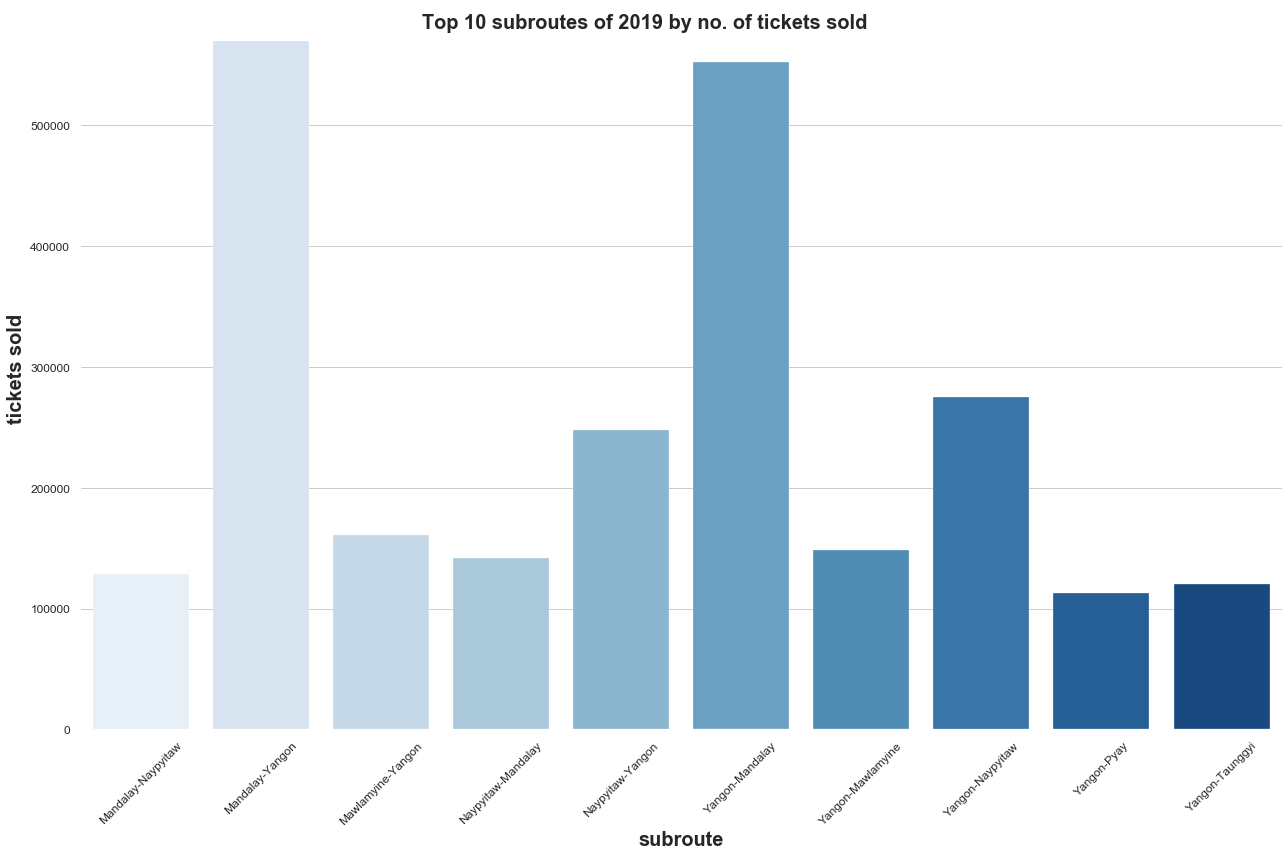

In [88]:
display(top10_subroute_tix)

plt.figure(figsize=(18,12))

sns.barplot(x=top10_subroute_tix.index, y = 'no_of_tickets', data=top10_subroute_tix, palette='Blues')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)
plt.xlabel('subroute', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('tickets sold', fontweight='bold', fontsize='20', horizontalalignment='center')

title = "Top 10 subroutes of 2019 by no. of tickets sold"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tight_layout()


From this, we can see that for 2019:

* Mandalay-Yangon and the corresponding Yangon-Mandalay are the highest performing routes by no. of tickets sold
* About twice as many tickets were sold for the Mandalay-Yangon / Yangon-Mandalay subroutes, compared to the next nearest pair for Yangon-Naypyitaw/Naypyitaw-Yangon.



## top 10 subroutes of 2019 based on net value earned

In [43]:
top10_subroute_earnings = subroute_sales[['total_net_amt']].sort_values(by='total_net_amt', ascending=False).head(10)

In [44]:
# rounding to the nearest million
top10_subroute_earnings['round'] = top10_subroute_earnings['total_net_amt'] / 1_000_000
top10_subroute_earnings

,total_net_amt,round
subroute_name,,
Mandalay-Yangon,8.167105e+09,8167.104860
Yangon-Mandalay,8.034671e+09,8034.671427
Yangon-Naypyitaw,1.982163e+09,1982.162819
Naypyitaw-Yangon,1.808202e+09,1808.202214
Muse-Yangon,1.708135e+09,1708.134777
Yangon-Lashio,1.689326e+09,1689.325697
Yangon-Taunggyi,1.563213e+09,1563.212540
Yangon-Kale,1.516905e+09,1516.905000
Yangon-Muse,1.492654e+09,1492.654043


subroute_name
Mandalay-Yangon     8167.104860
Yangon-Mandalay     8034.671427
Yangon-Naypyitaw    1982.162819
Naypyitaw-Yangon    1808.202214
Muse-Yangon         1708.134777
Yangon-Lashio       1689.325697
Yangon-Taunggyi     1563.212540
Yangon-Kale         1516.905000
Yangon-Muse         1492.654043
Taunggyi-Yangon     1413.100039
Name: round, dtype: float64

Text(0.5, 0.98, 'Top 10 subroutes of 2019 by net earnings')

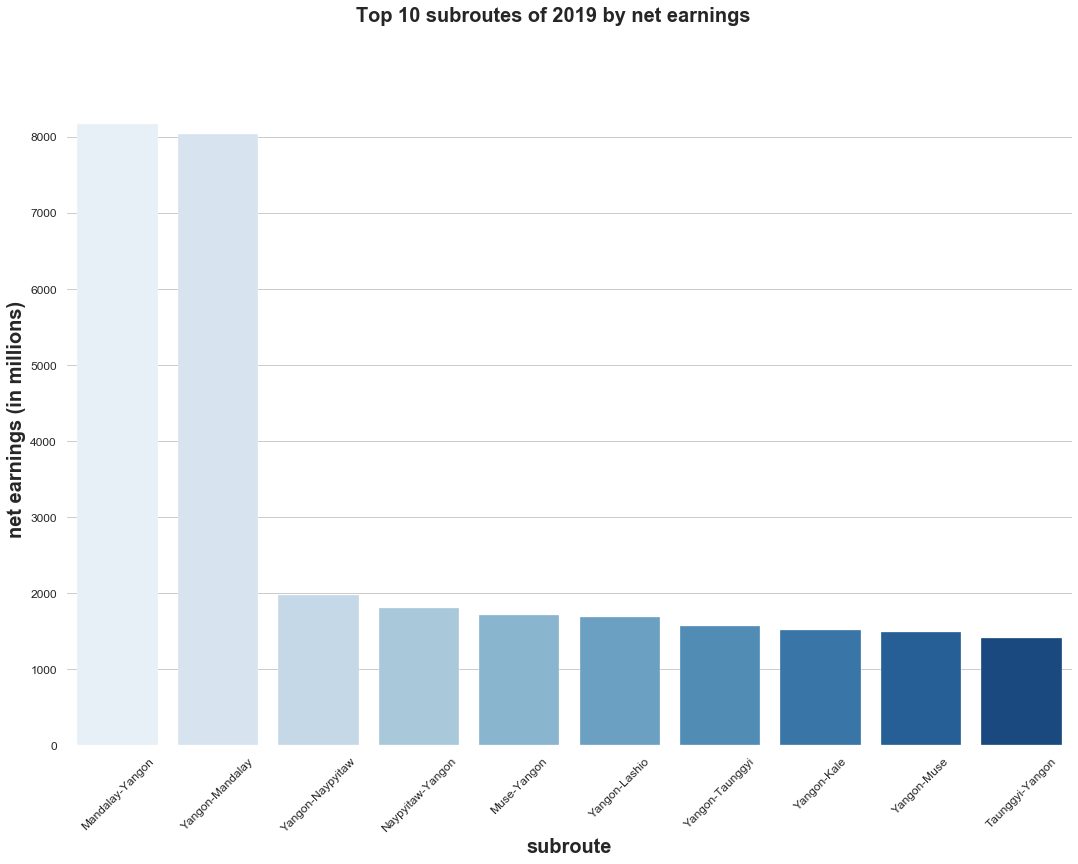

In [43]:
display(top10_subroute_earnings['round'])

plt.figure(figsize=(18,12))

sns.barplot(x=top10_subroute_earnings.index, y = 'round', data=top10_subroute_earnings, palette='Blues')

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=45)
plt.xlabel('subroute', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('net earnings (in millions)', fontweight='bold', fontsize='20', horizontalalignment='center')

title = "Top 10 subroutes of 2019 by net earnings"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

# plt.tight_layout()


Not surprisingly, the Mandalay-Yangon pair dominates this new chart that's sorted by net revenue, followed by the Yangon-Naypyitaw pair.

Based on real-world understanding, we can deduce that these four routes are so popular because Yangon and Mandalay are the biggest cities, and Naypyitaw is also significant because it's the capital. These routes also possibly command higher ticket prices because they're likely frequented by business people with higher earning power. 

However, the line-up from 5th position onwrads is a little different. For instance, in the chart organised by no of tickets booked, the Yangon-Mawlamyine pair takes 5th and 6th position, whereas for the chart organised by net earnings, those spots go to Muse-Yangon and Yangon-Lashio.

## bus prices distribution

In [36]:
top10_subroute_names = [ i for i in top10_subroute_tix.index ]
top10_subroute_names

['Mandalay-Naypyitaw',
 'Mandalay-Yangon',
 'Mawlamyine-Yangon',
 'Naypyitaw-Mandalay',
 'Naypyitaw-Yangon',
 'Yangon-Mandalay',
 'Yangon-Mawlamyine',
 'Yangon-Naypyitaw',
 'Yangon-Pyay',
 'Yangon-Taunggyi']

In [47]:
top10_df = trip_stats_df[trip_stats_df['subroute_name'].isin(top10_subroute_names)].copy()

In [48]:
display(top10_df.shape)

top10_df.head()

(1592274, 52)

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
22,10901777,3972,NaT,2019-08-15 09:19:14.175,2019-08-15 09:19:11.215,2418-8917,CONFIRMED,AGENT,722243,None,False,1,18,True,DEPOSIT,None,11386560,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10901803,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon
23,10904398,5937,NaT,2019-08-15 12:56:13.988,2019-08-15 12:56:13.505,2232-8939,CONFIRMED,OPERATOR,722243,None,False,1,18,True,DEPOSIT,None,11389489,621,FEMALE_ONLY,0.0,None,None,12800.0,0.0,12800.0,10904424,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon
24,10904670,5937,NaT,2019-08-15 13:18:32.192,2019-08-15 13:18:31.828,4464-7688,CONFIRMED,OPERATOR,722243,None,False,1,18,True,DEPOSIT,None,11389786,621,MALE_ONLY,0.0,None,None,12800.0,0.0,12800.0,10904696,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon
25,10906149,3180,NaT,2019-08-15 15:34:04.809,2019-08-15 15:34:04.397,3228-3788,CONFIRMED,OPERATOR,722243,None,True,1,18,True,DEPOSIT,None,11391429,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10906175,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon
26,10906526,3965,NaT,2019-08-15 16:05:19.109,2019-08-15 16:05:17.212,9996-8563,CONFIRMED,AGENT,722243,None,False,1,18,True,DEPOSIT,None,11391811,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10906552,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon


Text(0.5, 0.98, 'Histogram of local ticket prices for top 10 subroutes')

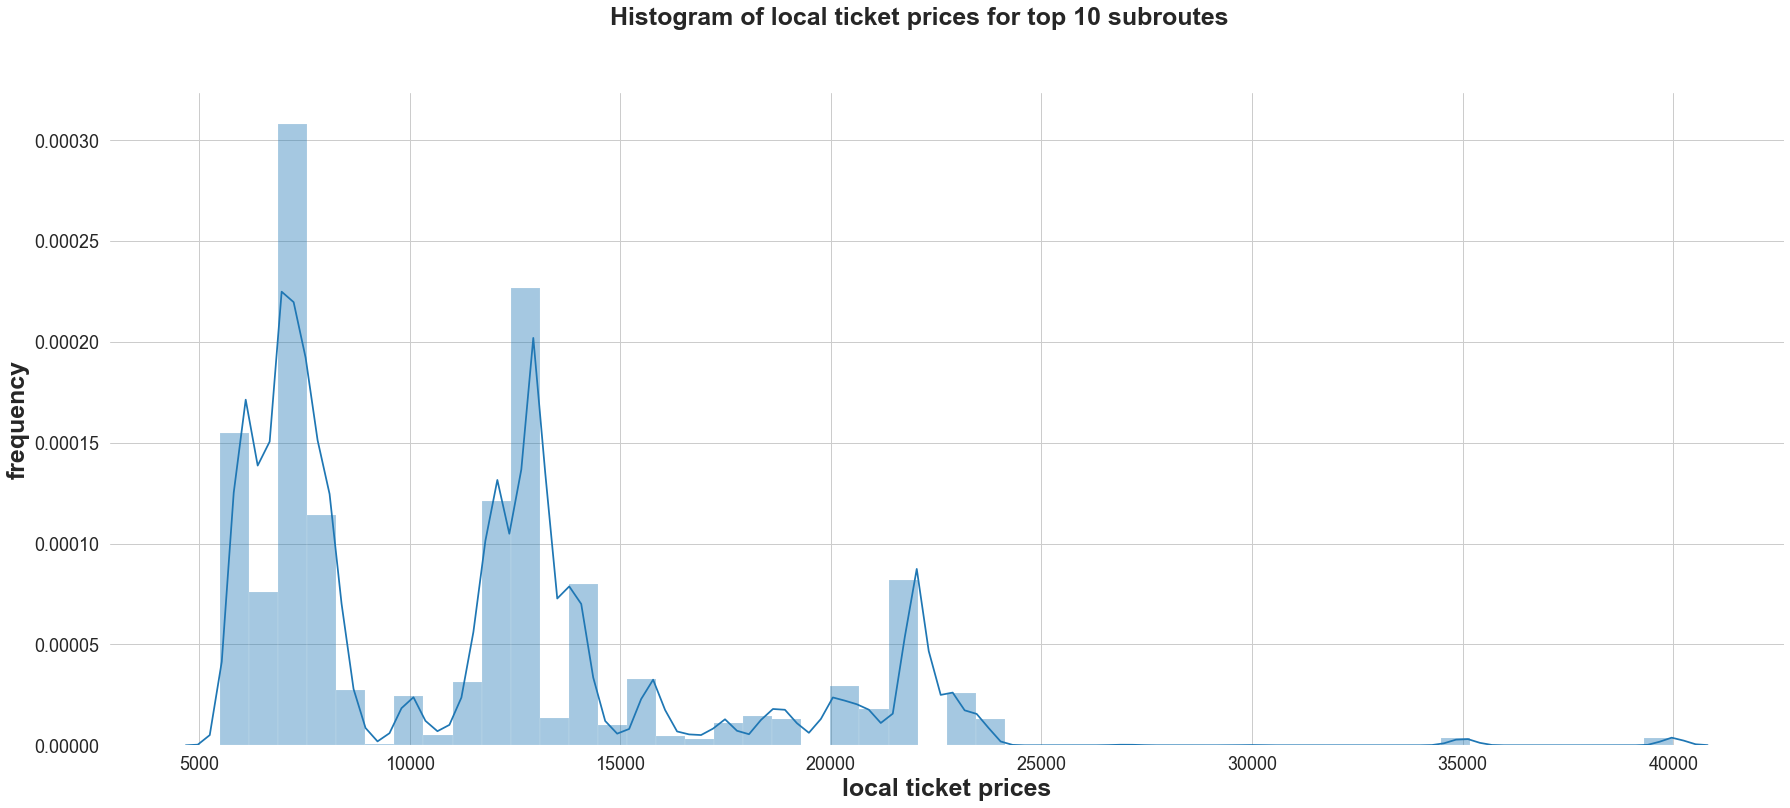

In [92]:
plt.figure(figsize=(30,12))

sns.distplot(top10_df[['local_amt']], bins=50)

plt.xlabel('local ticket prices', fontweight='bold', fontsize='25', horizontalalignment='center')
plt.ylabel('frequency', fontweight='bold', fontsize='25', horizontalalignment='center')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.suptitle('Histogram of local ticket prices for top 10 subroutes', fontweight='bold', fontsize='25', horizontalalignment='center')


Text(0.5, 0.98, 'Boxplot of local ticket prices for too 10 subroutes')

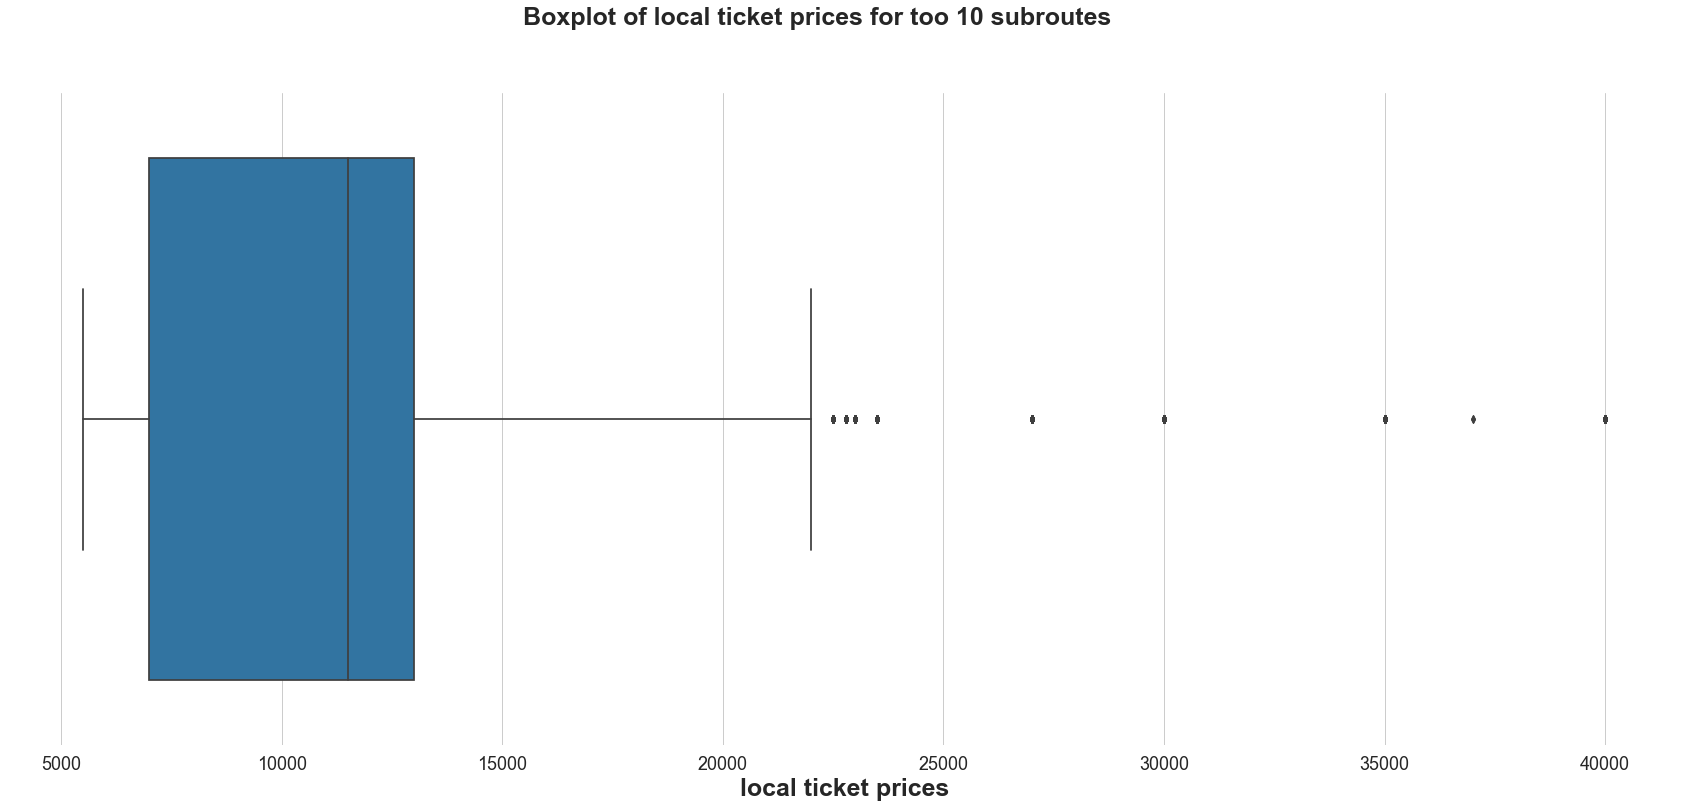

In [48]:
plt.figure(figsize=(30,12))

sns.boxplot(top10_df[['local_amt']], )

plt.xlabel('local ticket prices', fontweight='bold', fontsize='25', horizontalalignment='center')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.suptitle('Boxplot of local ticket prices for too 10 subroutes', fontweight='bold', fontsize='25', horizontalalignment='center')


In [49]:
top10_df['local_amt'].min(), top10_df['local_amt'].max()

(5500.0, 40000.0)

In [50]:
q1, q3= np.percentile(top10_df['local_amt'],[25,75])
print(f"Q1 is: {q1}")
print(f"Q2 is: {top10_df['local_amt'].median()}")
print(f"Q3 is: {q3}")
iqr = q3 - q1
print(f"IQR is: {iqr}")
print(f"max is:{q3 + (1.5*iqr)} ")

Q1 is: 7000.0
Q2 is: 11500.0
Q3 is: 13000.0
IQR is: 6000.0
max is:22000.0 


In [53]:
# for route in top10_subroute_names:
    
# #     print(route)
# #     display(top10_df[top10_df['subroute_name'] == route].shape)
# #     display(top10_df[top10_df['subroute_name'] == route]['local_amt'])
#     temp_df = top10_df[top10_df['subroute_name'] == route]['local_amt']
    
#     plt.figure(figsize=(30,8))

#     sns.distplot(temp_df, bins=50)

#     plt.xlabel('local ticket prices', fontweight='bold', fontsize='25', horizontalalignment='center')
#     plt.ylabel('frequency', fontweight='bold', fontsize='25', horizontalalignment='center')
#     plt.tick_params(axis='both', which='major', labelsize=18)

#     plt.suptitle(f'Histogram of local ticket prices for {route}', fontweight='bold', fontsize='25', horizontalalignment='center')

# #     print("\n---\n")
    

Text(0.5, 0.98, 'Boxplot of local ticket prices by subroute')

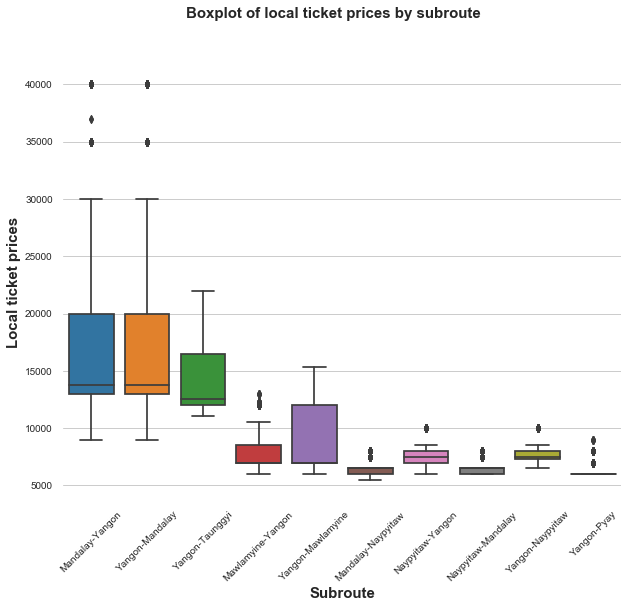

In [54]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x='subroute_name', y='local_amt', data=top10_df[['local_amt', 'subroute_name']])
plt.xlabel('Subroute', fontweight='bold', fontsize='15', horizontalalignment='center')
plt.ylabel('Local ticket prices', fontweight='bold', fontsize='15', horizontalalignment='center')
plt.xticks(rotation=45)
plt.suptitle('Boxplot of local ticket prices by subroute', fontweight='bold', fontsize='15', horizontalalignment='center')



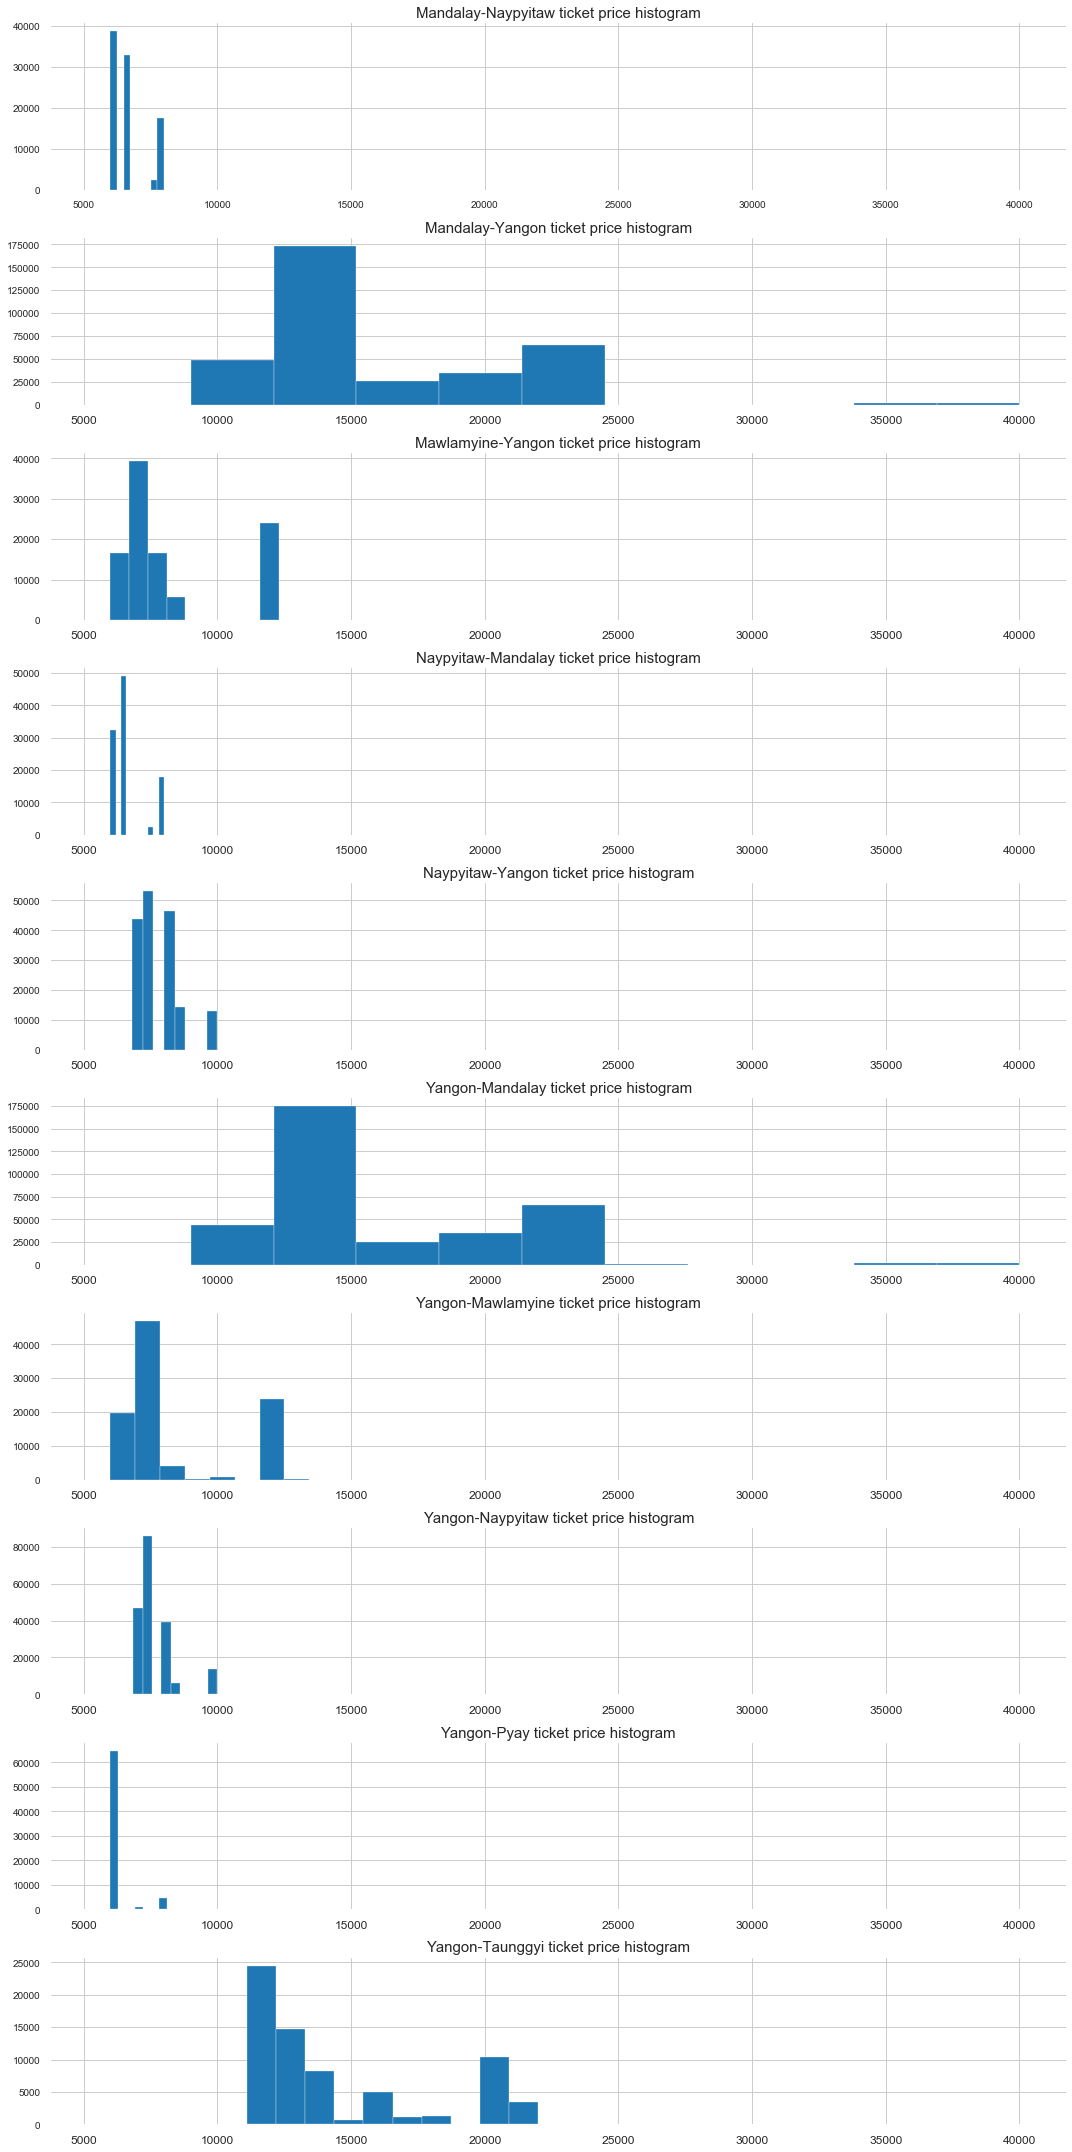

In [25]:
fig = plt.figure(figsize=(15,30))

ax1 = fig.add_subplot(10,1,1)
temp_df = top10_df[top10_df['subroute_name'] == top10_subroute_names[0]]['local_amt']
ax1.hist(temp_df)
plt.setp(ax1.get_xticklabels(), fontsize=10)
plt.title(f"{top10_subroute_names[0]} ticket price histogram", fontsize=15)
plt.tight_layout()

for i in range(1,10):

    temp_df = top10_df[top10_df['subroute_name'] == top10_subroute_names[i]]['local_amt']
    ax2 = fig.add_subplot(10,1,i+1, sharex=ax1)
    ax2.hist(temp_df)
    plt.title(f"{top10_subroute_names[i]} ticket price histogram", fontsize=15)

    plt.setp(ax2.get_xticklabels(), fontsize=12)
    plt.tight_layout()



So far it appears that ticket prices for these routes are generally < 10,000 with very little variance, though there are still some outliers

* Mandalay-Naypyitaw
* Naypyitaw-Yangon
* Naypyitaw-Mandalay
* Yangon-Taunggyi
* Yangon-Nanypyitaw
* Yangon-Pyay


## cleaning up bus types

These are all the bus categories (as advertised by bus operators) we have:

In [26]:
top10_df['bus_cat'].value_counts().sort_index()

(Scania Marcopolo) Special One          5458
(Scania) Standard                      86070
Business Class                          8071
Business Class Morning                  6105
First Class                            39832
Gold Class                              6194
Gold Class-B New                        4860
Marcopolo Scania VIP                     818
Premier Class                           1677
Premier Class (VIP 2+1)                 9465
Premier Class(VIP 2+1)                  3329
Royal Class B Day                        625
Royal Class Day                          123
Scania (Business Class)                43564
Scania - Standard                     103029
Scania- Lite Tan                        9594
Special Bus                            17587
Standard                              524875
Standard                                5188
Standard  45                            2918
Standard (2+2)                          4515
Standard (45)                            872
Standard (

**Real world info**

From interviews with the business owners, we've learned that

* `tk_bus_type.name_en` (alias `bus_cat` in our dataframe), which denotes to the qualitative category of a bus, is completely at the discretion of the bus companies. This explains why sometimes a bus is marked as 'Standard', sometimes ' Standard Scania' etc, depending on what the bus company uses to categorise.
* The amenities/facilities available on each bus is not listed on the website so it's hard to objectively order the bus types; there's always the possibility that a bus operator might give a grander bus type description than a specific bus warrants. 
* However, in reality there are meaningfully just three categories which we can loosely refer to as (to borrow from airline terms) Economy, Premium, Business. 
* Although there may be some differences within a category depending on the model and furnishing of a bus, the main difference between the categories is really the seat formation of a bus. So a bus with a 2 + 2 seat layout is equivalent to Economy, a 2 + 1 seat layout is considered Premium, and a 1 + 1 seat layout is considered Business. 
* Since `bus_cat` is effectively not reliable, we should use the seat formation to map the actual bus category. This we need to derive from `tk_bus_type.num_of_column` (alias `seat_formation` in our dataframe). When the layout is 2+2, it's recorded as `seat_formation` = 5 in our dataframe (to account for the aisle column); the 2 + 1 layout is recorded as 4; and the 1 + 1 layout is recorded as 3. 
* The kicker, however, is that there are a few (or maybe just one?) buses that have the 1 + 1 + 1 seat layout. It's considered Premium, but carries `seat_formation` = 5! Unfortunately, the only way to pick out such a bus is by checking `bus_cat` for a description that says '1+1+1'. Even the business owner is not 100% certain how many such buses there are, but since they're probably quite few... they might not make a huge impact.

In [39]:
# function to map the appropriate class based on `seat_formation`

def map_class(val):
    if val == 5:
        bus_class = 0
    if val == 4:
        bus_class = 1
    if val == 3:
        bus_class = 2
    
    return bus_class

In [50]:
# `bus_class` will be an ordinal feature
top10_df['bus_class'] = top10_df['seat_formation'].apply(map_class)

In [51]:
# verifying that the numbers were mapped correctly

print(top10_df['seat_formation'].value_counts(dropna=False))

print(top10_df['bus_class'].value_counts(dropna=False))

5    1199679
4     384728
3       7867
Name: seat_formation, dtype: int64
0    1199679
1     384728
2       7867
Name: bus_class, dtype: int64


In [52]:
top10_df.to_pickle("./data/top10_data.pkl")


# modeling: predicting no. of tickets sold

We want to predict the number of tickets sold 

**using these features**
* bus company (`operator_id`)
* local vs foreigner (`is_foreigner`)
* tickets sold (`no_of_tickets`)
* bus category (`bus_class`)
* subroute (`subroute_name`, to be one-hot-encoded)
* price (`local_amt`)
* departure time (`depart_hour`)
* duration (`duration_minutes`)
* month (`trip_month`)
* week of the year (`weekofyear`)
* day of the week (`dayofweek`)
* day of year (`dayofyear`)

In [30]:
top10_df.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name,bus_class
22,10901777,3972,NaT,2019-08-15 09:19:14.175,2019-08-15 09:19:11.215,2418-8917,CONFIRMED,AGENT,722243,None,False,1,18,True,DEPOSIT,None,11386560,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10901803,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon,0
23,10904398,5937,NaT,2019-08-15 12:56:13.988,2019-08-15 12:56:13.505,2232-8939,CONFIRMED,OPERATOR,722243,None,False,1,18,True,DEPOSIT,None,11389489,621,FEMALE_ONLY,0.0,None,None,12800.0,0.0,12800.0,10904424,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon,0
24,10904670,5937,NaT,2019-08-15 13:18:32.192,2019-08-15 13:18:31.828,4464-7688,CONFIRMED,OPERATOR,722243,None,False,1,18,True,DEPOSIT,None,11389786,621,MALE_ONLY,0.0,None,None,12800.0,0.0,12800.0,10904696,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon,0
25,10906149,3180,NaT,2019-08-15 15:34:04.809,2019-08-15 15:34:04.397,3228-3788,CONFIRMED,OPERATOR,722243,None,True,1,18,True,DEPOSIT,None,11391429,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10906175,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon,0
26,10906526,3965,NaT,2019-08-15 16:05:19.109,2019-08-15 16:05:17.212,9996-8563,CONFIRMED,AGENT,722243,None,False,1,18,True,DEPOSIT,None,11391811,621,FEMALE_ONLY,0.0,None,None,12800.0,2000.0,10800.0,10906552,722207,False,False,722207,2019-08-16 05:00:00,2019-08-15 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,12800.0,Standard,5,20,5,540.0,8,33,227,3,Mandalay-Yangon,0


In [43]:
pref_cols = [
        'operator_id',
        'is_foreigner',
        'no_of_tickets',
        'bus_class',
        'subroute_name',
        'local_amt',
        'depart_hour',
        'arrive_hour',
        'duration_minutes',
        'trip_month',
        'weekofyear',
        'dayofweek',
        'dayofyear',
            ]

In [54]:
model_df = top10_df[pref_cols].copy()
print(model_df.shape)
model_df.head()

(1592274, 14)


,operator_id,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,18,False,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,18,False,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,18,False,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,18,True,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,18,False,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [55]:
# mapping `is_foreigner` into numeric type
model_df['is_foreigner'] = model_df['is_foreigner'].astype(int)
model_df.head()

,operator_id,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,18,1,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [56]:
# dropping the extra operator_id column

model_df = model_df.iloc[:,1:].copy()
print(model_df.shape)

model_df.head()

(1592274, 13)


,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,1,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


## saving the model data to pickle

In [57]:
model_df.to_pickle("./data/model_data2.pkl")

pkl_model = pd.read_pickle("./data/model_data2.pkl")

# 2018 data

In [5]:
sql_statement = (
    """
SELECT
		tk_booking_detail.*,
		tk_trip.*,
		tk_sub_route.source_location_id,
		tk_location_source.name AS source_location_name,
		tk_sub_route.destination_location_id,
		tk_location_destination.name AS destination_location_name,
		tk_sub_route_price_linkage.local_amt AS local_amt,
		tk_bus_type.name_en as bus_cat,
		tk_bus_type.num_of_column as seat_formation
	FROM
		tk_booking_detail
	LEFT JOIN tk_trip ON
		tk_booking_detail.trip_id = tk_trip.trip_id
	LEFT JOIN tk_sub_route ON
		tk_booking_detail.sub_route_id = tk_sub_route.sub_route_id
	LEFT JOIN tk_location AS tk_location_source ON
		tk_sub_route.source_location_id = tk_location_source.location_id
	LEFT JOIN tk_location AS tk_location_destination ON
		tk_sub_route.destination_location_id = tk_location_destination.location_id
	LEFT JOIN tk_sub_route_price_linkage ON
		tk_sub_route.sub_route_id = tk_sub_route_price_linkage.subroute_id and tk_booking_detail.trip_id = tk_sub_route_price_linkage.trip_id
	LEFT JOIN tk_bus_type on
		tk_trip.bus_type_id = tk_bus_type.bus_type_id
	WHERE
		DATE_PART('year', tk_trip.departure) = '2018'
		AND tk_trip.trip_status = 'BOOKABLE'


    """
                )
trip_stats2018 = query_db(sql_statement)


Connected!

SELECT
		tk_booking_detail.*,
		tk_trip.*,
		tk_sub_route.source_location_id,
		tk_location_source.name AS source_location_name,
		tk_sub_route.destination_location_id,
		tk_location_destination.name AS destination_location_name,
		tk_sub_route_price_linkage.local_amt AS local_amt,
		tk_bus_type.name_en as bus_cat,
		tk_bus_type.num_of_column as seat_formation
	FROM
		tk_booking_detail
	LEFT JOIN tk_trip ON
		tk_booking_detail.trip_id = tk_trip.trip_id
	LEFT JOIN tk_sub_route ON
		tk_booking_detail.sub_route_id = tk_sub_route.sub_route_id
	LEFT JOIN tk_location AS tk_location_source ON
		tk_sub_route.source_location_id = tk_location_source.location_id
	LEFT JOIN tk_location AS tk_location_destination ON
		tk_sub_route.destination_location_id = tk_location_destination.location_id
	LEFT JOIN tk_sub_route_price_linkage ON
		tk_sub_route.sub_route_id = tk_sub_route_price_linkage.subroute_id and tk_booking_detail.trip_id = tk_sub_route_price_linkage.trip_id
	LEFT JOIN tk_bus_typ

In [6]:
trip_stats2018.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_notify_date,booking_ref_number,booking_status,booking_type,bus_id,comment,created_by,creation_date,description,device_number,device_phone_number,discount_percentage,is_foreigner,modified_by,modified_date,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,special_request,sub_route_id,traveller_group_type,vendor_id,version,discount_amt,discount_cur,lat,lng,payment_fee_amt,payment_fee_cur,total_amt,total_amt_cur,total_commission_amt,total_commission_cur,total_net_amt,total_net_cur,traveller_contact_id,trip_id,agent_name,agenttag,is_agent,log,sub_account_id,subaccountname,is_sub_agent,sub_payment_type,total_net_sub_amt,total_net_sub_amt_cur,total_sub_commission_amt,total_sub_commission_amt_cur,total_sub_payment_fee_amt,total_sub_payment_fee_amt_cur,application_type,installation_id,user_email,trip_id,arrival,bus_classification_type,created_by,creation_date,departure,description,modified_by,modified_date,operator_id,trip_code,trip_status,vendor_id,version,gate_id,route_id,bus_type_id,amenity_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation
0,5285327,2972,NaT,2018-06-29 08:31:04.051,2018-06-29 08:30:59.809,None,4814-6724,CONFIRMED,AGENT,362501,None,2972,2018-06-29 08:30:59.817,None,0c624792-65a0-4690-bbb7-e361ae42873b,None,None,False,11089,2018-07-01 20:19:44.961,1,18,True,DEPOSIT,None,5447614,,533,MALE_ONLY,None,5,0.0,MMK,None,None,None,None,10800.0,MMK,2000.0,MMK,8800.0,MMK,5285336,362469,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,362469,2018-06-30 06:05:00,None,3150,2018-06-28 18:33:43.674,2018-06-29 21:05:00,None,11089,2018-06-28 18:34:24.839,18,None,BOOKABLE,None,2,NaN,164,62,None,150,Yangon,151,Mandalay,10800.0,Standard,5
1,3249118,130,NaT,2018-01-02 18:36:03.002,2018-01-02 18:35:58.842,None,3318-3116,CONFIRMED,AGENT,193307,None,130,2018-01-02 18:35:58.850,None,38fa8a3a-ddc9-4b21-b419-ab2702e0f8ec,None,None,False,130,2019-03-14 17:24:55.157,2,2,True,DEPOSIT,None,3340887,,43,MALE_ONLY,None,5,0.0,MMK,None,None,None,None,21000.0,MMK,2000.0,MMK,19000.0,MMK,3249126,193305,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,193305,2018-01-05 06:00:00,None,10726,2017-11-09 13:15:49.168,2018-01-04 19:00:00,None,10726,2017-11-09 13:15:49.168,2,None,BOOKABLE,None,1,2.0,4,2,None,3,Yangon,8,Ngathayauk,10500.0,Standard,5
2,3267042,603,NaT,2018-01-04 12:33:27.502,2018-01-04 12:33:23.600,None,9827-7198,CONFIRMED,AGENT,193307,None,603,2018-01-04 12:33:23.608,None,f71a7065-4ee1-4663-b154-7b7faf4b140d,None,None,False,73,2018-02-14 21:09:17.449,1,2,True,DEPOSIT,None,3359248,B 0520,40,MALE_ONLY,None,5,0.0,MMK,None,None,None,None,9500.0,MMK,1000.0,MMK,8500.0,MMK,3267050,193305,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,193305,2018-01-05 06:00:00,None,10726,2017-11-09 13:15:49.168,2018-01-04 19:00:00,None,10726,2017-11-09 13:15:49.168,2,None,BOOKABLE,None,1,2.0,4,2,None,3,Yangon,4,Kyauk Padaung,9500.0,Standard,5
3,3267764,82,NaT,2018-01-04 13:36:01.967,2018-01-04 13:35:58.665,None,9253-5673,CONFIRMED,AGENT,193307,None,82,2018-01-04 13:35:58.673,None,ceb69278-724c-4b59-9800-825cd9f74d21,None,None,False,73,2018-02-08 12:16:14.810,1,2,True,DEPOSIT,None,3359980,[HK] ၀၅၉၄၃၄. ဂိတ္​စီး ထက,43,MALE_ONLY,None,5,0.0,MMK,None,None,None,None,10500.0,MMK,1000.0,MMK,9500.0,MMK,3267772,193305,None,None,False,None,None,None,False,None,None,None,None,None,None,None,None,None,None,193305,2018-01-05 06:00:00,None,10726,2017-11-09 13:15:49.168,2018-01-04 19:00:00,None,10726,2017-11-09 13:15:49.168,2,None,BOOKABLE,None,1,2.0,4,2,None,3,Yangon,8,Ngathayauk,10500.0,Standard,5
4,3270467,225,NaT,2018-01-04 17:06:19.125,2018-01-04 17:06:03.102,None,7164-7584,CONFIRMED,OPERATOR,193307,None,883,2018-01-04 17:06:03.110,None,fadd9714-e934-4c62-a3a2-f83ea4150b17,None,None,F

## saving full 2018 dataset to pickle

In [7]:
trip_stats2018.to_pickle("./data/2018_data.pkl")

## cleaning & pre-processing

We will
* drop irrelevant columns
* create granular datetime features
    * departure hour
    * arrival hour
    * journey duration
    * month
    * week_of_year
    * day_of_week
    * day_of_year

In [10]:
df_2018 = trip_stats2018.copy()
df_2018 = df_2018.drop(columns=drop_cols)
df_2018.shape

(4364693, 44)

In [12]:
# extracting the departure hour
df_2018['depart_hour'] = df_2018['departure'].dt.hour

# extracting the arrival hour
df_2018['arrive_hour'] = df_2018['arrival'].dt.hour

# calculating trip duration
df_2018['duration_minutes'] = (df_2018['arrival']-df_2018['departure']).astype('timedelta64[m]')
df_2018['duration_minutes']

# extracting month of trip
df_2018['trip_month'] = df_2018['departure'].dt.month

# more date features
df_2018['weekofyear'] = df_2018['departure'].dt.weekofyear
df_2018['dayofyear'] = df_2018['departure'].dt.dayofyear
df_2018['dayofweek'] = df_2018['departure'].dt.dayofweek

In [14]:
# replacing destination and source names
df_2018['destination_location_name'] = df_2018['destination_location_name'].replace(mapper)
df_2018['source_location_name'] = df_2018['source_location_name'].replace(mapper)

# creating `subroute_name` by concatenating source and destination
df_2018['subroute_name'] = df_2018['source_location_name'] + '-' + df_2018['destination_location_name']
df_2018[['source_location_name', 'destination_location_name', 'subroute_name']]

,source_location_name,destination_location_name,subroute_name
0,Yangon,Mandalay,Yangon-Mandalay
1,Yangon,Ngathayauk,Yangon-Ngathayauk
2,Yangon,Kyauk Padaung,Yangon-Kyauk Padaung
3,Yangon,Ngathayauk,Yangon-Ngathayauk
4,Yangon,Ngathayauk,Yangon-Ngathayauk
...,...,...,...
4364688,Yangon,Pyin Oo Lwin,Yangon-Pyin Oo Lwin
4364689,Yangon,Pyin Oo Lwin,Yangon-Pyin Oo Lwin
4364690,Yangon,Pyin Oo Lwin,Yangon-Pyin Oo Lwin
4364691,Yangon,Pyin Oo Lwin,Yangon-Pyin Oo Lwin


In [15]:
df_2018.head()

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
0,5285327,2972,NaT,2018-06-29 08:31:04.051,2018-06-29 08:30:59.809,4814-6724,CONFIRMED,AGENT,362501,None,False,1,18,True,DEPOSIT,None,5447614,533,MALE_ONLY,0.0,None,None,10800.0,2000.0,8800.0,5285336,362469,False,False,362469,2018-06-30 06:05:00,2018-06-29 21:05:00,18,BOOKABLE,NaN,164,62,150,Yangon,151,Mandalay,10800.0,Standard,5,21,6,540.0,6,26,180,4,Yangon-Mandalay
1,3249118,130,NaT,2018-01-02 18:36:03.002,2018-01-02 18:35:58.842,3318-3116,CONFIRMED,AGENT,193307,None,False,2,2,True,DEPOSIT,None,3340887,43,MALE_ONLY,0.0,None,None,21000.0,2000.0,19000.0,3249126,193305,False,False,193305,2018-01-05 06:00:00,2018-01-04 19:00:00,2,BOOKABLE,2.0,4,2,3,Yangon,8,Ngathayauk,10500.0,Standard,5,19,6,660.0,1,1,4,3,Yangon-Ngathayauk
2,3267042,603,NaT,2018-01-04 12:33:27.502,2018-01-04 12:33:23.600,9827-7198,CONFIRMED,AGENT,193307,None,False,1,2,True,DEPOSIT,None,3359248,40,MALE_ONLY,0.0,None,None,9500.0,1000.0,8500.0,3267050,193305,False,False,193305,2018-01-05 06:00:00,2018-01-04 19:00:00,2,BOOKABLE,2.0,4,2,3,Yangon,4,Kyauk Padaung,9500.0,Standard,5,19,6,660.0,1,1,4,3,Yangon-Kyauk Padaung
3,3267764,82,NaT,2018-01-04 13:36:01.967,2018-01-04 13:35:58.665,9253-5673,CONFIRMED,AGENT,193307,None,False,1,2,True,DEPOSIT,None,3359980,43,MALE_ONLY,0.0,None,None,10500.0,1000.0,9500.0,3267772,193305,False,False,193305,2018-01-05 06:00:00,2018-01-04 19:00:00,2,BOOKABLE,2.0,4,2,3,Yangon,8,Ngathayauk,10500.0,Standard,5,19,6,660.0,1,1,4,3,Yangon-Ngathayauk
4,3270467,225,NaT,2018-01-04 17:06:19.125,2018-01-04 17:06:03.102,7164-7584,CONFIRMED,OPERATOR,193307,None,False,9,2,True,DEPOSIT,None,3362762,43,MIXED,0.0,None,None,94500.0,0.0,94500.0,3270475,193305,False,False,193305,2018-01-05 06:00:00,2018-01-04 19:00:00,2,BOOKABLE,2.0,4,2,3,Yangon,8,Ngathayauk,10500.0,Standard,5,19,6,660.0,1,1,4,3,Yangon-Ngathayauk


In [16]:
# inspecting  null rows
df_2018[df_2018['local_amt'].isnull()]

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
2555891,5784788,12091,NaT,2018-08-13 12:03:12.617,2018-08-13 12:03:10.384,5172-4508,CONFIRMED,AGENT,375806,None,False,1,28,True,DEPOSIT,None,5964292,1933,MALE_ONLY,0.0,None,None,10000.0,1000.0,9000.0,5784798,375774,False,False,375774,2018-08-14 08:00:00,2018-08-13 19:00:00,28,BOOKABLE,930.0,579,202,421,Yangon,489,Myingyan,NaN,Standard,5,19,8,780.0,8,33,225,0,Yangon-Myingyan


In [18]:
# dropping rows where `local_amt` is null

print(df_2018.shape)
df_2018.dropna(subset=['local_amt'], inplace=True)
print(df_2018.shape)
df_2018[df_2018['local_amt'].isnull()]

(4364693, 52)
(4364692, 52)


,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name


In [19]:
df_2018[df_2018['local_amt'] < 1_000]


,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
857388,3757723,7522,NaT,2018-02-18 12:21:01.550,2018-02-18 12:21:01.060,1587-7393,CONFIRMED,OPERATOR,266570,None,False,1,17,True,DEPOSIT,None,3864293,1028,MALE_ONLY,0.0,None,None,0.0,0.0,0.0,3757732,266538,True,False,266538,2018-02-19 16:05:00,2018-02-19 09:05:00,17,BOOKABLE,NaN,375,151,316,Mandalay,177,Taunggyi,0.0,Small Car Front Seat,4,9,16,420.0,2,8,50,0,Mandalay-Taunggyi
904967,3810032,9852,2018-02-22 18:04:30.949,2018-02-22 18:03:27.509,2018-02-22 18:03:27.033,2668-7734,CANCELED,OPERATOR,269456,None,False,1,17,False,DEPOSIT,None,3918166,1304,MALE_ONLY,0.0,None,None,0.0,0.0,0.0,3810041,269424,False,False,269424,2018-02-24 17:15:00,2018-02-24 09:15:00,17,BOOKABLE,NaN,438,151,177,Taunggyi,316,Mandalay,0.0,Small Car Front Seat,4,9,17,480.0,2,8,55,5,Taunggyi-Mandalay
1027475,4224528,9041,2018-04-01 09:25:32.352,2018-03-26 14:20:34.162,2018-03-26 14:20:30.836,8838-8441,CANCELED,AGENT,276431,None,False,4,22,True,DEPOSIT,None,4348029,1568,MIXED,0.0,None,None,44000.0,8000.0,36000.0,4224537,276399,False,False,276399,2018-04-02 02:00:00,2018-04-01 11:00:00,22,BOOKABLE,643.0,496,170,293,Muse,291,Mandalay,0.0,Standard,5,11,2,900.0,4,13,91,6,Muse-Mandalay
1231106,4263731,11410,NaT,2018-03-29 09:11:11.233,2018-03-29 09:11:10.678,6550-9142,CONFIRMED,OPERATOR,274241,None,False,1,22,True,DEPOSIT,None,4388824,1568,MALE_ONLY,0.0,None,None,0.0,0.0,0.0,4263740,274209,False,False,274209,2018-03-30 02:00:00,2018-03-29 11:00:00,22,BOOKABLE,643.0,496,170,293,Muse,291,Mandalay,0.0,Standard,5,11,2,900.0,3,13,88,3,Muse-Mandalay
1312735,4369065,9852,2018-04-04 19:24:56.791,2018-04-04 18:43:56.735,2018-04-04 18:43:56.295,2269-7365,CANCELED,OPERATOR,296367,None,False,1,17,False,DEPOSIT,None,4499117,1319,FEMALE_ONLY,0.0,None,None,0.0,0.0,0.0,4369074,296335,False,False,296335,2018-04-12 17:00:00,2018-04-12 09:00:00,17,BOOKABLE,NaN,439,70,177,Taunggyi,316,Mandalay,0.0,VIP,4,9,17,480.0,4,15,102,3,Taunggyi-Mandalay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254620,7213232,13193,NaT,2018-12-05 10:25:35.014,2018-12-05 10:25:34.947,9634-1129,CONFIRMED,AGENT,479575,None,False,1,32,False,DEPOSIT,None,7455290,2360,FEMALE_ONLY,0.0,None,None,10.0,1.0,9.0,7213242,479542,False,False,479542,2018-12-20 12:00:00,2018-12-20 02:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,10.0,Departure from Near Tamwe Shwe Baho Cinema,5,2,12,600.0,12,51,354,3,Taze-Monywa
4254621,7229584,13193,NaT,2018-12-06 11:24:29.423,2018-12-06 11:24:29.398,9869-1168,CONFIRMED,AGENT,479575,None,False,1,32,False,DEPOSIT,None,7472381,2360,MALE_ONLY,0.0,None,None,10.0,1.0,9.0,7229594,479542,False,False,479542,2018-12-20 12:00:00,2018-12-20 02:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,10.0,Departure from Near Tamwe Shwe Baho Cinema,5,2,12,600.0,12,51,354,3,Taze-Monywa
4254622,7291995,13193,NaT,2018-12-10 15:47:34.804,2018-12-10 15:47:34.712,8611-1214,CONFIRMED,AGENT,479575,None,False,1,32,False,DEPOSIT,None,7537688,2360,MALE_ONLY,0.0,None,None,10.0,1.0,9.0,7292005,479542,False,False,479542,2018-12-20 12:00:00,2018-12-20 02:00:00,32,BOOKABLE,NaN,704,243,597,Taze,502,Monywa,10.0,Departure from Near Tamwe Shwe Baho Cinema,5,2

In [21]:
# dropping rows where prices are < 1,000
display(df_2018.shape)
df_2018 = df_2018[~(df_2018['local_amt'] < 1_000)]
display(df_2018.shape)
df_2018[df_2018['local_amt'] < 1_000]


(4364561, 52)

(4364561, 52)

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name


In [22]:
# inspecting rows with unreasonably high `local_amt`
df_2018[df_2018['local_amt'] > 100_000]

,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
1454208,4580249,10673,NaT,NaT,2018-04-29 13:03:02.951,2813-3112,PROCESSING,AGENT,303180,None,True,1,3,False,None,None,4720815,143,MALE_ONLY,0.0,None,None,600000.0,0.0,600000.0,4580258,303148,False,False,303148,2018-05-10 05:00:00,2018-05-09 19:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,600000.0,(Scania) Standard,5,19,5,600.0,5,19,129,2,Myawaddy-Yangon
1454209,4644339,10673,NaT,NaT,2018-05-04 13:28:51.134,7615-4782,PROCESSING,AGENT,303180,None,True,1,3,False,None,None,4786860,143,MALE_ONLY,0.0,None,None,600000.0,0.0,600000.0,4644348,303148,False,False,303148,2018-05-10 05:00:00,2018-05-09 19:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,600000.0,(Scania) Standard,5,19,5,600.0,5,19,129,2,Myawaddy-Yangon
1454210,4646444,87,2018-05-04 15:57:02.031,2018-05-04 15:56:56.090,2018-05-04 15:56:55.750,3689-8011,CANCELED,OPERATOR,303180,None,False,1,3,False,DEPOSIT,None,4789104,143,FEMALE_ONLY,0.0,None,None,600000.0,0.0,600000.0,4646453,303148,False,False,303148,2018-05-10 05:00:00,2018-05-09 19:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,600000.0,(Scania) Standard,5,19,5,600.0,5,19,129,2,Myawaddy-Yangon
1454211,4647305,10673,NaT,NaT,2018-05-04 16:51:51.409,8662-6807,PROCESSING,AGENT,303180,None,True,1,3,False,None,None,4789981,143,MALE_ONLY,0.0,None,None,600000.0,0.0,600000.0,4647314,303148,False,False,303148,2018-05-10 05:00:00,2018-05-09 19:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,600000.0,(Scania) Standard,5,19,5,600.0,5,19,129,2,Myawaddy-Yangon
1454212,4712849,1582,2018-05-09 21:13:14.418,2018-05-09 21:13:09.139,2018-05-09 21:13:08.740,6350-5174,CANCELED,OPERATOR,303180,None,False,1,3,False,DEPOSIT,None,4857679,143,MALE_ONLY,0.0,None,None,600000.0,0.0,600000.0,4712858,303148,False,False,303148,2018-05-10 05:00:00,2018-05-09 19:00:00,3,BOOKABLE,NaN,41,10,31,Myawaddy,13,Yangon,600000.0,(Scania) Standard,5,19,5,600.0,5,19,129,2,Myawaddy-Yangon


In [23]:
# dropping rows where prices are > 100,000
display(df_2018.shape)
df_2018 = df_2018[~(df_2018['local_amt'] > 100_000)]
display(df_2018.shape)

df_2018[df_2018['local_amt'] > 100_000]


(4364561, 52)

(4364556, 52)

In [25]:
# checking that trip_status are all 'BOOKABLE'
df_2018['trip_status'].value_counts(dropna=False)

BOOKABLE    4364556
Name: trip_status, dtype: int64

In [26]:
df_2018.to_pickle("./data/2018_cleaned_stats.pkl")

## extracting data only on top10 subroutes (based on 2019's top10)

In [37]:
top10_2018 = df_2018[df_2018['subroute_name'].isin(top10_subroute_names)].copy()

In [38]:
print(top10_2018.shape)
top10_2018.head()

(1757472, 52)


,booking_id,account_id,booking_cancel_date,booking_confirm_date,booking_date,booking_ref_number,booking_status,booking_type,bus_id,discount_percentage,is_foreigner,no_of_tickets,operator_id,is_paid,payment_type,promotion_code,reserved_seat_id,sub_route_id,traveller_group_type,discount_amt,payment_fee_amt,payment_fee_cur,total_amt,total_commission_amt,total_net_amt,traveller_contact_id,trip_id,is_agent,is_sub_agent,trip_id,arrival,departure,operator_id,trip_status,gate_id,route_id,bus_type_id,source_location_id,source_location_name,destination_location_id,destination_location_name,local_amt,bus_cat,seat_formation,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofyear,dayofweek,subroute_name
0,5285327,2972,NaT,2018-06-29 08:31:04.051,2018-06-29 08:30:59.809,4814-6724,CONFIRMED,AGENT,362501,None,False,1,18,True,DEPOSIT,None,5447614,533,MALE_ONLY,0.0,None,None,10800.0,2000.0,8800.0,5285336,362469,False,False,362469,2018-06-30 06:05:00,2018-06-29 21:05:00,18,BOOKABLE,NaN,164,62,150,Yangon,151,Mandalay,10800.0,Standard,5,21,6,540.0,6,26,180,4,Yangon-Mandalay
15,5868288,3937,NaT,2018-08-21 09:08:41.583,2018-08-21 09:08:38.038,7364-8214,CONFIRMED,AGENT,402904,None,False,2,18,True,DEPOSIT,None,6050605,621,MIXED,0.0,None,None,21600.0,4000.0,17600.0,5868298,402872,False,False,402872,2018-08-22 05:00:00,2018-08-21 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,10800.0,Standard,5,20,5,540.0,8,34,233,1,Mandalay-Yangon
16,5869145,3044,NaT,2018-08-21 10:20:03.809,2018-08-21 10:19:59.304,6134-1495,CONFIRMED,AGENT,402904,None,False,1,18,True,DEPOSIT,None,6051513,621,MALE_ONLY,0.0,None,None,10800.0,2000.0,8800.0,5869155,402872,False,False,402872,2018-08-22 05:00:00,2018-08-21 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,10800.0,Standard,5,20,5,540.0,8,34,233,1,Mandalay-Yangon
17,5869580,3965,NaT,2018-08-21 10:58:49.188,2018-08-21 10:58:44.432,8868-7134,CONFIRMED,AGENT,402904,None,False,1,18,True,DEPOSIT,None,6051969,621,MALE_ONLY,0.0,None,None,10800.0,2000.0,8800.0,5869590,402872,False,False,402872,2018-08-22 05:00:00,2018-08-21 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,10800.0,Standard,5,20,5,540.0,8,34,233,1,Mandalay-Yangon
18,5871566,5937,NaT,2018-08-21 14:06:22.852,2018-08-21 14:06:22.383,8246-2303,CONFIRMED,OPERATOR,402904,None,False,1,18,True,DEPOSIT,None,6054053,621,MALE_ONLY,0.0,None,None,10800.0,0.0,10800.0,5871576,402872,False,False,402872,2018-08-22 05:00:00,2018-08-21 20:00:00,18,BOOKABLE,NaN,195,62,151,Mandalay,150,Yangon,10800.0,Standard,5,20,5,540.0,8,34,233,1,Mandalay-Yangon


In [40]:
# `bus_class` will be an ordinal feature
top10_2018['bus_class'] = top10_2018['seat_formation'].apply(map_class)

In [41]:
# verifying that the numbers were mapped correctly

print(top10_2018['seat_formation'].value_counts(dropna=False))

print(top10_2018['bus_class'].value_counts(dropna=False))

5    1361756
4     386976
3       8740
Name: seat_formation, dtype: int64
0    1361756
1     386976
2       8740
Name: bus_class, dtype: int64


In [44]:
model_2018 = top10_2018[pref_cols].copy()
print(model_2018.shape)
model_2018.head()

(1757472, 14)


,operator_id,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
0,18,18,False,1,0,Yangon-Mandalay,10800.0,21,6,540.0,6,26,4,180
15,18,18,False,2,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
16,18,18,False,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
17,18,18,False,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
18,18,18,False,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233


In [45]:
# mapping `is_foreigner` into numeric type
model_2018['is_foreigner'] = model_2018['is_foreigner'].astype(int)
model_2018.head()

,operator_id,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
0,18,18,0,1,0,Yangon-Mandalay,10800.0,21,6,540.0,6,26,4,180
15,18,18,0,2,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
16,18,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
17,18,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
18,18,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233


In [46]:
# dropping the extra operator_id column

model_2018 = model_2018.iloc[:,1:].copy()
print(model_2018.shape)

model_2018.head()

(1757472, 13)


,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
0,18,0,1,0,Yangon-Mandalay,10800.0,21,6,540.0,6,26,4,180
15,18,0,2,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
16,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
17,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
18,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233


## saving to pickle

In [47]:
model_2018.to_pickle("./data/model_2018.pkl")

pkl_model_2018 = pd.read_pickle("./data/model_2018.pkl")

# ? scraps

# real-world information
    
Notes from interviews with the business owners

**Purchase channels**
* direct from mmbusticket.com
* via mobile wallets (e.g. MPU, KBZ, CB, wave money)
* from travel agents
* from bus operators directly at terminals

Generally, we would consider ticket purchases made from the website and via mobile wallets to be direct purchases for two reasons
* the mobile interface is directly powered by MM Bus Ticket rather than an external party
* passenger details are entered by the purchaser himself/herself rather than by a counter staff at a travel agency/bus terminal


**Bus routes**
* Most cities only have one bus terminal. Only a handful of bigger cities (e.g. Yangon, Mandalay) have more than one bus terminal. 
* However, for a given route (e.g. Yangon-Mandalay), all buses depart from and arrive at the same bus terminals.
    * Hence, exact bus terminal information is not captured in the database.
    * This means we will not need to investigate if customers have preferred bus terminals because there isn't even a choice of bus terminals to begin with.
    
**Bus and seat types**
* Unlike in the case of airlines, bus operators in Burma don't have the practice of offering different seat categories within the same trip.
    * Therefore, all seats within a given trip (assuming the same sub-route) have the same price formula. 
* Instead, price differentiation happens at the bus type level (e.g. 'VIP', 'First Class'). So an operator for the Yangon-Mandalay route might offer several concurrent trips using different types of buses. A 'First Class' bus is typically more expensive than a 'Standard' bus.
    * However, from a technical viewpoint, it should be noted that these bus types are not normalized. For instance, `tk_bus_type` has multiple rows that have `description` = 'VIP' all with different bus. There is also no consistent format to the `description` field - e.g. there is 'Standard', ' Standard - Scania', 'Standard 44', 'Standard 49' etc. 
    * While we might be able to safely assume that 'First Class' is superior t 'Standard', it's harder to tell if 'Premier Class' is equivalent/higher/lower than 'First Class'. At best, these can be considered nominal categories rather than ordinal. 
* Neither the website nor the mobile interface (i.e. for mobile wallets) provide information on the amenities (e.g. whether seats can be reclined, if charging points are available at each seat) offered by each bus type. 
    * This means that if a foreign tourist is looking to make a direct purchase, he/she can only assume that a pricier ticket would offer more comfort than a cheaper ticket. 
    * Some locals might have a better idea of the differences among bus types/companies based on experience or here-say.
    * customers making purchases made via agents/bus operators may also be better informed because they have the opportunity to ask counter staff for clarifications.